Purpose of this script: quickly check that changing the functional form of the background fit doesn't change N_sig, N_bkg a lot

In [2]:

# Standard Imports
import numpy as np
import argparse
import os
import pickle
from sklearn.utils import shuffle


# Plotting
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
# from matplotlib.backends.backend_pdf import PdfPages
# from rikabplotlib.plot_utils import newplot, stamp, hist_with_outline, hist_with_errors
#!pip install rikabplotlib






from helpers.data_transforms import inverse_transform, clean_data
from helpers.BDT import run_BDT_bump_hunt
from helpers.physics_functions import bkg_fit_septic, bkg_fit_quintic, bkg_fit_cubic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import assemble_banded_datasets


# @RADHA: For your feature labels in the plotters, I recommend using r-strings, e.g r"$m_{\mu\um}$", since Perlmutter's LATEX environment is wonky
# @RADHA: I tried my best to remove the global imports (e.g. from helpers.BDT import *) since it makes the code extremely hard for me to read :{
# @RADHA: The calc_significance function was missing an argument of "center"


In [7]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
config_id = "CATHODE_8"
project_id = "lowmass"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)




In [8]:
flow_id = "mix_1"
particle_type = "upsilon_iso"
num_to_ensemble = 5
num_bootstraps = 1
dir_id = "logit_08_22"
jet_id = "nojet"
seeds = "1,2,3,4,5"
train_samesign = False

In [9]:
if "upsilon" in particle_type:
    particle_id = "upsilon"
elif "psi_prime" in particle_type:
    particle_id = "psi_prime"
elif "eta" in particle_type:
    particle_id = "eta"
elif "rho" in particle_type:
    particle_id = "rho"
elif "psi" in particle_type:
    particle_id = "psi"

project_id = "lowmass"

if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

    

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/{dir_id}/"
flow_training_dir = f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}"


In [10]:
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

print(f"SB_left: {SB_left}")
print(f"SR_left: {SR_left}")
print(f"SR_right: {SR_right}")
print(f"SB_right: {SB_right}")

SB_left: 7.8
SR_left: 9.0
SR_right: 10.6
SB_right: 14.0


In [5]:
# load in the flow samples corresponding to the train id
seeds_list = [int(x) for x in seeds.split(",")]
train_samples_dict = {'SR_samples_ROC':[], 'SBL_samples_ROC':[], 'SBH_samples_ROC':[], 'SR_samples_validation':[], 'SR_samples':[]}
for seed in seeds_list:
    path_to_samples = f"{flow_training_dir}/seed{seed}/flow_samples"
    with open(path_to_samples, "rb") as infile: 
        loc_train_samples_dict = pickle.load(infile)
        for key in train_samples_dict.keys():
            train_samples_dict[key].append(loc_train_samples_dict[key])
for key in train_samples_dict.keys():
    train_samples_dict[key] = np.vstack(train_samples_dict[key])
    print(key, train_samples_dict[key].shape)
           


# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

# load in the alternative data
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{alt_test_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    alt_test_data_dict = pickle.load(infile)


with open(f"{working_dir}/processed_data/{project_id}_{particle_type}_{jet_id}_train_band_data", "rb") as infile: 
    ROC_test_data_1_dict = pickle.load(infile)
    
# ROC set 2 is evaluated on a higher stats version of the flow samples (so may be same or opp sign)

print(f"Loading classifier train samples from {project_id}_{particle_type}{train_data_id}")
print(f"Loading classifier train data from {project_id}_{particle_type}{train_data_id}")
print(f"Loading alternative test data from {project_id}_{particle_type}{alt_test_data_id}")
print(f"Loading ROC test data from {project_id}_{particle_type}_{jet_id}")
print()

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(feature_set)

n_features = len(feature_set) - 1


NameError: name 'seeds' is not defined

In [6]:
# Assemble the test sets -- consists of both SB and SR
        
# test set events: not used during flow training
banded_test_data = assemble_banded_datasets(test_data_dict, feature_set, bands)

# alt test set events
banded_alt_test_data = assemble_banded_datasets(alt_test_data_dict, feature_set, bands)

# ROC test set events
banded_ROC_test_data = assemble_banded_datasets(ROC_test_data_1_dict, feature_set, bands)

num_test_events = banded_test_data["SR"].shape[0]+banded_test_data["SBL"].shape[0]+banded_test_data["SBH"].shape[0]
print(f"Total number of default test events: {num_test_events}.")
num_test_events = banded_alt_test_data["SR"].shape[0]+banded_alt_test_data["SBL"].shape[0]+banded_alt_test_data["SBH"].shape[0]
print(f"Total number of alt test events: {num_test_events}.")
num_test_events = banded_ROC_test_data["SR"].shape[0]+banded_ROC_test_data["SBL"].shape[0]+banded_ROC_test_data["SBH"].shape[0]
print(f"Total number of ROC test events: {num_test_events}.")
num_test_events = banded_ROC_test_data["SR"].shape[0]+banded_ROC_test_data["SBL"].shape[0]+banded_ROC_test_data["SBH"].shape[0]
print(f"Total number of ROC test samples: {num_test_events}.")


SR_min_rescaled = np.min(banded_test_data["SR"][:,-1])
SR_max_rescaled = np.max(banded_test_data["SR"][:,-1])



NameError: name 'test_data_dict' is not defined

In [7]:



# BDT HYPERPARAMETERS 



bdt_hyperparams_dict = {
    "n_estimators": 300, # number of boosting stages
    "max_depth":3, # max depth of individual regression estimators; related to complexity
    "learning_rate":0.1,  # stop training BDT is validation loss doesn't improve after this many rounds
    "subsample":0.7,   # fraction of samples to be used for fitting the individual base learners
    "early_stopping_rounds":10,
    "n_ensemble": num_to_ensemble
    
}

n_folds = 5

all_test_data_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_scores_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_alt_data_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_alt_scores_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}

def bootstrap_array(data_array):
    indices_to_take = np.random.choice(range(data_array.shape[0]), size = data_array.shape[0], replace = True) 
    #return data_array[indices_to_take]
    return data_array

for pseudo_e in range(num_bootstraps):
    
    print(f"On pseudoexperiment {pseudo_e+1} of {num_bootstraps}...")
    
    # assemble the bootstrapped datasets
    # I think the validation set and the flow samples should NOT be bootstrapped
    
    # boostrapped alt set:
    loc_alt_test_set = np.vstack([bootstrap_array(banded_alt_test_data["SR"]),bootstrap_array(banded_alt_test_data["SBL"]),bootstrap_array(banded_alt_test_data["SBH"])])
    loc_ROC_test_events_1 = np.vstack([bootstrap_array(banded_ROC_test_data["SR"]),bootstrap_array(banded_ROC_test_data["SBL"]),bootstrap_array(banded_ROC_test_data["SBH"])])
    loc_ROC_test_samples_2 = np.vstack([bootstrap_array(train_samples_dict["SR_samples_ROC"]),bootstrap_array(train_samples_dict["SBL_samples_ROC"]),bootstrap_array(train_samples_dict["SBH_samples_ROC"])])
    loc_SB_test_set = np.vstack([bootstrap_array(clean_data(banded_test_data["SBL"])),bootstrap_array(clean_data(banded_test_data["SBH"]))])
    loc_FPR_val_set = train_samples_dict["SR_samples_validation"]
    loc_SR_data = clean_data(banded_test_data["SR"])
    loc_SR_samples = clean_data(train_samples_dict["SR_samples"])
    

    loc_alt_test_sets_data = {"FPR_validation":loc_FPR_val_set,
                      "alt":loc_alt_test_set,
                      "ROC_data":loc_ROC_test_events_1,
                     "ROC_samples":loc_ROC_test_samples_2}
    
    # make sure the input data is also bootstrapped
    loc_test_data_splits, loc_scores_splits, loc_alt_data_splits, loc_alt_scores_splits = run_BDT_bump_hunt(loc_SR_samples, bootstrap_array(loc_SR_data), loc_SB_test_set, n_folds, bdt_hyperparams_dict, alt_test_sets_data=loc_alt_test_sets_data, visualize=False, pdf=None, take_ensemble_avg=True)

    all_test_data_splits[pseudo_e] = loc_test_data_splits
    all_scores_splits[pseudo_e] = loc_scores_splits
    all_alt_data_splits[pseudo_e] = loc_alt_data_splits
    all_alt_scores_splits[pseudo_e] = loc_alt_scores_splits
    
    
    print(10*"*"+"\n")

print("Done training BDTs!")


On pseudoexperiment 1 of 1...
Fold 0:
X train shape: (335298, 3), Y train shape: (335298, 1), w train shape: (335298, 1).
X val shape: (111766, 3), Y val shape: (111766, 1), w val shape: (111766, 1).
X test shape: (5000, 3).
   Network number: 0
Fold 1:
X train shape: (335298, 3), Y train shape: (335298, 1), w train shape: (335298, 1).
X val shape: (111766, 3), Y val shape: (111766, 1), w val shape: (111766, 1).
X test shape: (5000, 3).
   Network number: 0
Fold 2:
X train shape: (335298, 3), Y train shape: (335298, 1), w train shape: (335298, 1).
X val shape: (111766, 3), Y val shape: (111766, 1), w val shape: (111766, 1).
X test shape: (5000, 3).
   Network number: 0
Fold 3:
X train shape: (335298, 3), Y train shape: (335298, 1), w train shape: (335298, 1).
X val shape: (111766, 3), Y val shape: (111766, 1), w val shape: (111766, 1).
X test shape: (4999, 3).
   Network number: 0
Fold 4:
X train shape: (335298, 3), Y train shape: (335298, 1), w train shape: (335298, 1).
X val shape: (

In [ ]:



with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.002]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}

for pseudo_e in range(num_bootstraps):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

print(f"SB_left: {SB_left}")
print(f"SR_left: {SR_left}")
print(f"SR_right: {SR_right}")
print(f"SB_right: {SB_right}")

    

NameError: name 'working_dir' is not defined

In [9]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 12)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    plt.figure(figsize = (12, 8))
    for t, threshold in enumerate(fpr_thresholds):

        # corrections to SR / SB efficiencies
        filtered_masses = []

        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)

        filtered_masses = np.concatenate(filtered_masses)
        print(filtered_masses)
        print()

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        # plot the fit function
        #plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")  
        #plot_centers_all_2 = np.concatenate((plot_centers_left, plot_centers_right))
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")   
        
 
        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        #label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))
        label_string = str(round(100*threshold, 2))+"% FPR: S: "+str(round(num_S_expected_in_SR,2))+", B: "+str(round(num_B_expected_in_SR,2))+"$\pm$"+str(np.round(B_error,2))+",S/B: "+str(round(S_over_B,5))+", sig: "+str(round(significance,5))

        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
        
        fpr_results[threshold]["S"] = round(num_S_expected_in_SR,0)
        fpr_results[threshold]["B"] = round(num_B_expected_in_SR,0)
        fpr_results[threshold]["S_over_B"] = round(S_over_B,2)
        fpr_results[threshold]["signif"] = round(significance,2)


    plt.legend(loc = (1, 0), fontsize = 12)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)

    plt.title(title, fontsize = 24)
    
    return fpr_results
    


<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1224856/1562019244.py:51: SyntaxWarning: invalid escape sequence '\p'
  label_string = str(round(100*threshold, 2))+"% FPR: S: "+str(round(num_S_expected_in_SR,2))+", B: "+str(round(num_B_expected_in_SR,2))+"$\pm$"+str(np.round(B_error,2))+",S/B: "+str(round(S_over_B,5))+", sig: "+str(round(significance,5))
/tmp/ipykernel_1224856/1562019244.py:68: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)


[[ 9.60186488]
 [ 9.17496197]
 [10.12626264]
 ...
 [13.53367034]
 [13.34615328]
 [ 8.92391289]]

[[10.33150101]
 [ 9.23853785]
 [10.36746882]
 ...
 [14.71635052]
 [10.88949867]
 [12.46367076]]

[[ 9.23853785]
 [ 9.0516548 ]
 [10.41272348]
 ...
 [14.52483086]
 [13.18942546]
 [10.88949867]]

[[ 9.23853785]
 [ 9.0516548 ]
 [10.41272348]
 ...
 [14.35724534]
 [ 8.40481087]
 [14.52483086]]

[[ 9.57200135]
 [ 9.96197787]
 [ 9.52781671]
 [10.18785089]
 [10.27966784]
 [ 9.51150598]
 [ 9.90057364]
 [ 8.62115368]
 [ 8.62967584]
 [ 8.41736599]
 [ 8.95943545]
 [ 8.66724299]
 [11.23616792]
 [ 8.03632552]
 [ 8.62470242]
 [ 9.99327658]
 [10.18636411]
 [ 9.40599069]
 [10.06290527]
 [ 9.91989803]
 [12.91916367]
 [ 7.84487081]
 [ 8.10705757]
 [ 9.4509419 ]
 [ 9.24862387]
 [ 9.49240958]
 [ 9.37108603]
 [ 9.46753297]
 [ 9.17666526]
 [ 9.48125942]
 [10.21468164]
 [ 9.38231464]
 [ 9.8227701 ]
 [ 9.52808006]
 [ 9.59167867]
 [ 9.46490196]
 [11.2107821 ]
 [ 7.96212968]
 [ 8.80443753]
 [14.01444039]
 [ 9.3457946

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


[[10.33150101]
 [ 9.23853785]
 [10.36746882]
 ...
 [14.71635052]
 [10.88949867]
 [12.46367076]]

[[ 9.23853785]
 [ 9.0516548 ]
 [10.41272348]
 ...
 [14.52483086]
 [13.18942546]
 [10.88949867]]

[[ 9.23853785]
 [ 9.0516548 ]
 [10.41272348]
 ...
 [14.35724534]
 [ 8.40481087]
 [14.52483086]]

[[ 9.57200135]
 [ 9.96197787]
 [ 9.52781671]
 [10.18785089]
 [10.27966784]
 [ 9.51150598]
 [ 9.90057364]
 [ 8.62115368]
 [ 8.62967584]
 [ 8.41736599]
 [ 8.95943545]
 [ 8.66724299]
 [11.23616792]
 [ 8.03632552]
 [ 8.62470242]
 [ 9.99327658]
 [10.18636411]
 [ 9.40599069]
 [10.06290527]
 [ 9.91989803]
 [12.91916367]
 [ 7.84487081]
 [ 8.10705757]
 [ 9.4509419 ]
 [ 9.24862387]
 [ 9.49240958]
 [ 9.37108603]
 [ 9.46753297]
 [ 9.17666526]
 [ 9.48125942]
 [10.21468164]
 [ 9.38231464]
 [ 9.8227701 ]
 [ 9.52808006]
 [ 9.59167867]
 [ 9.46490196]
 [11.2107821 ]
 [ 7.96212968]
 [ 8.80443753]
 [14.01444039]
 [ 9.34579465]
 [10.16936677]
 [ 9.46358571]
 [10.00137423]
 [ 9.48294446]
 [ 9.94322303]
 [11.25645733]
 [ 8

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


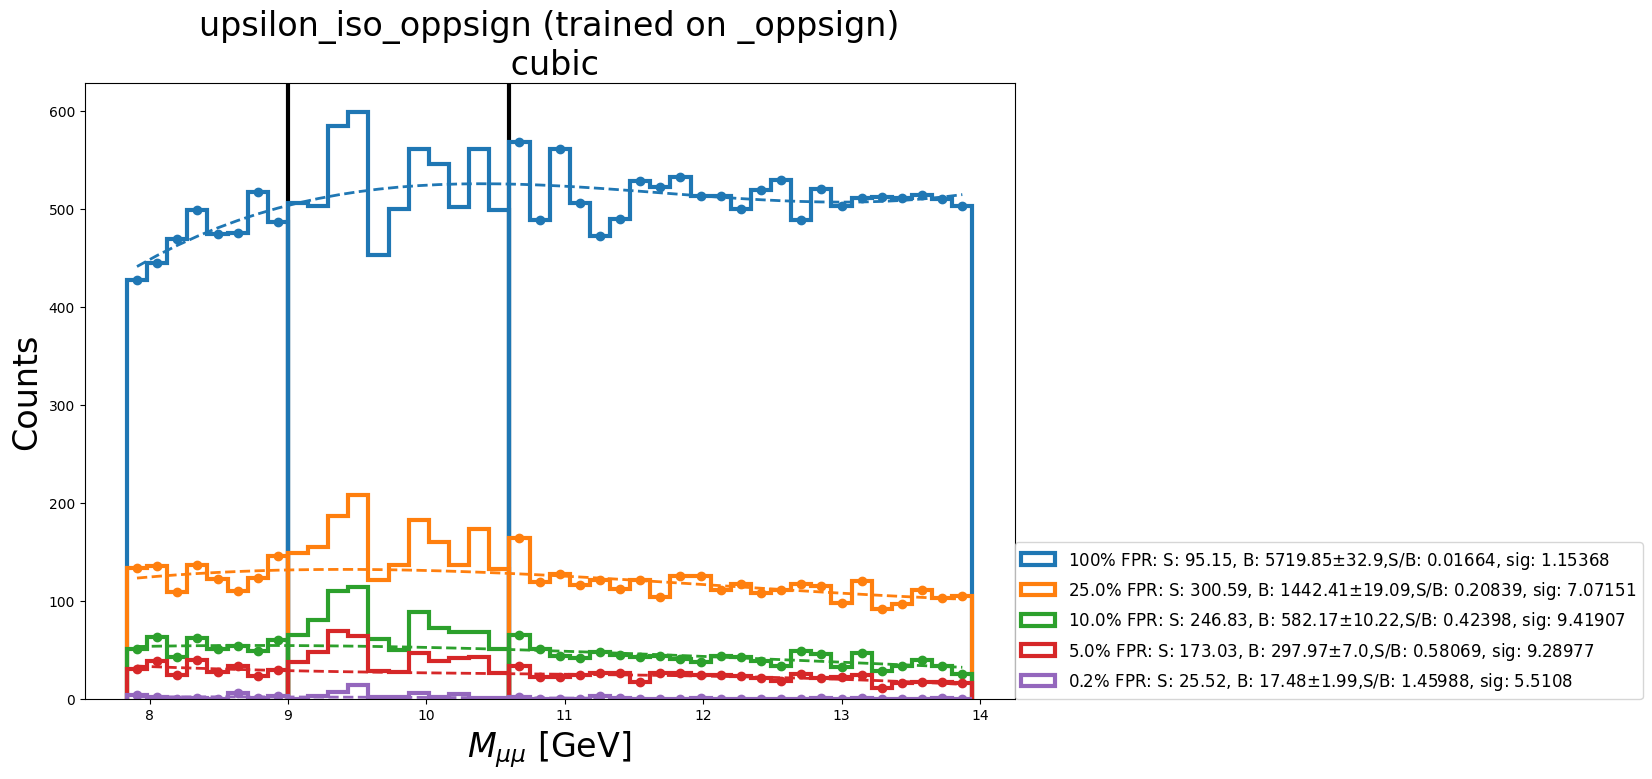

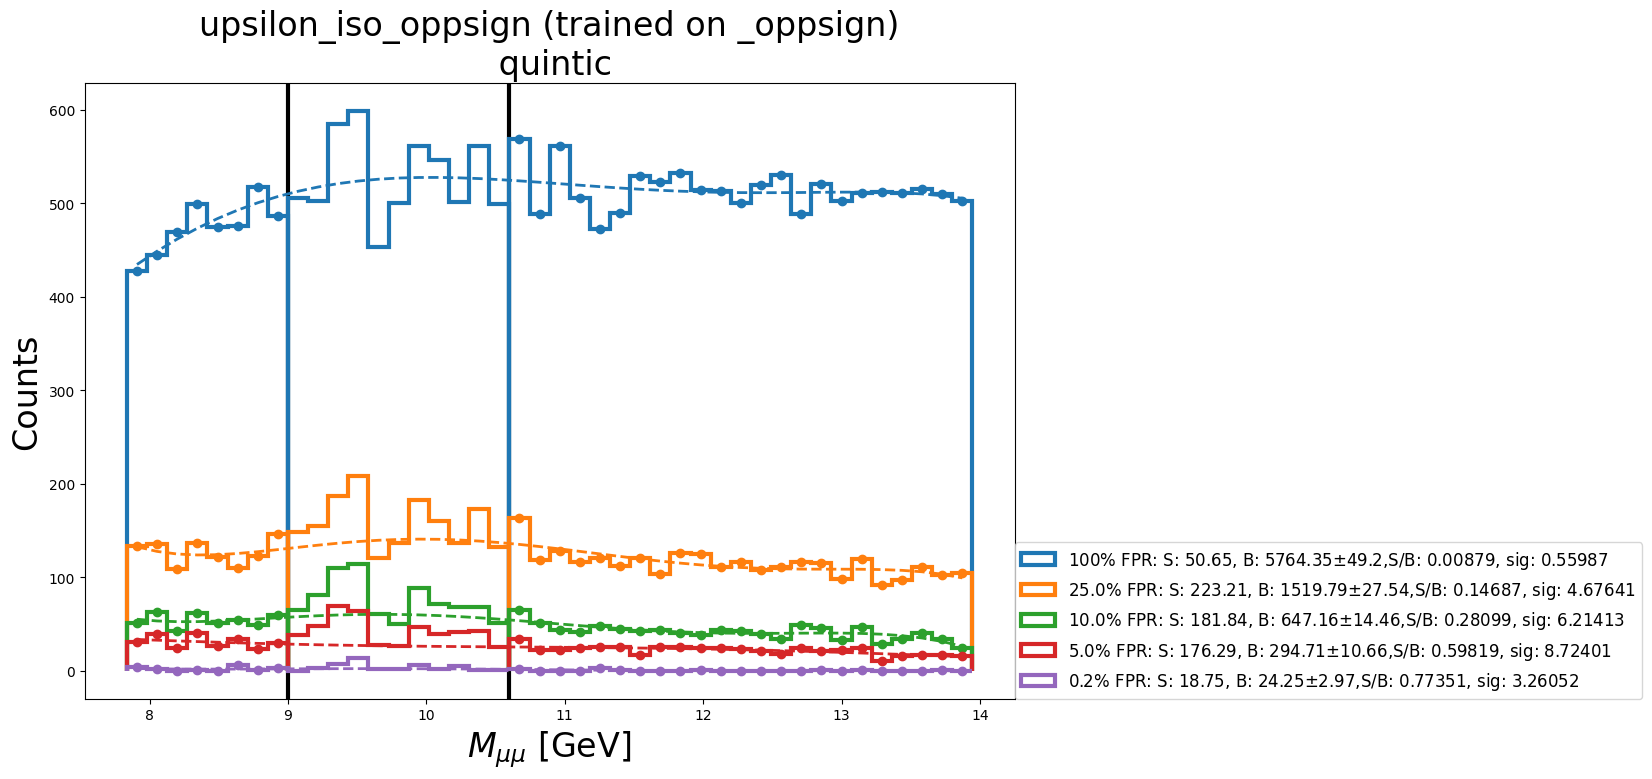

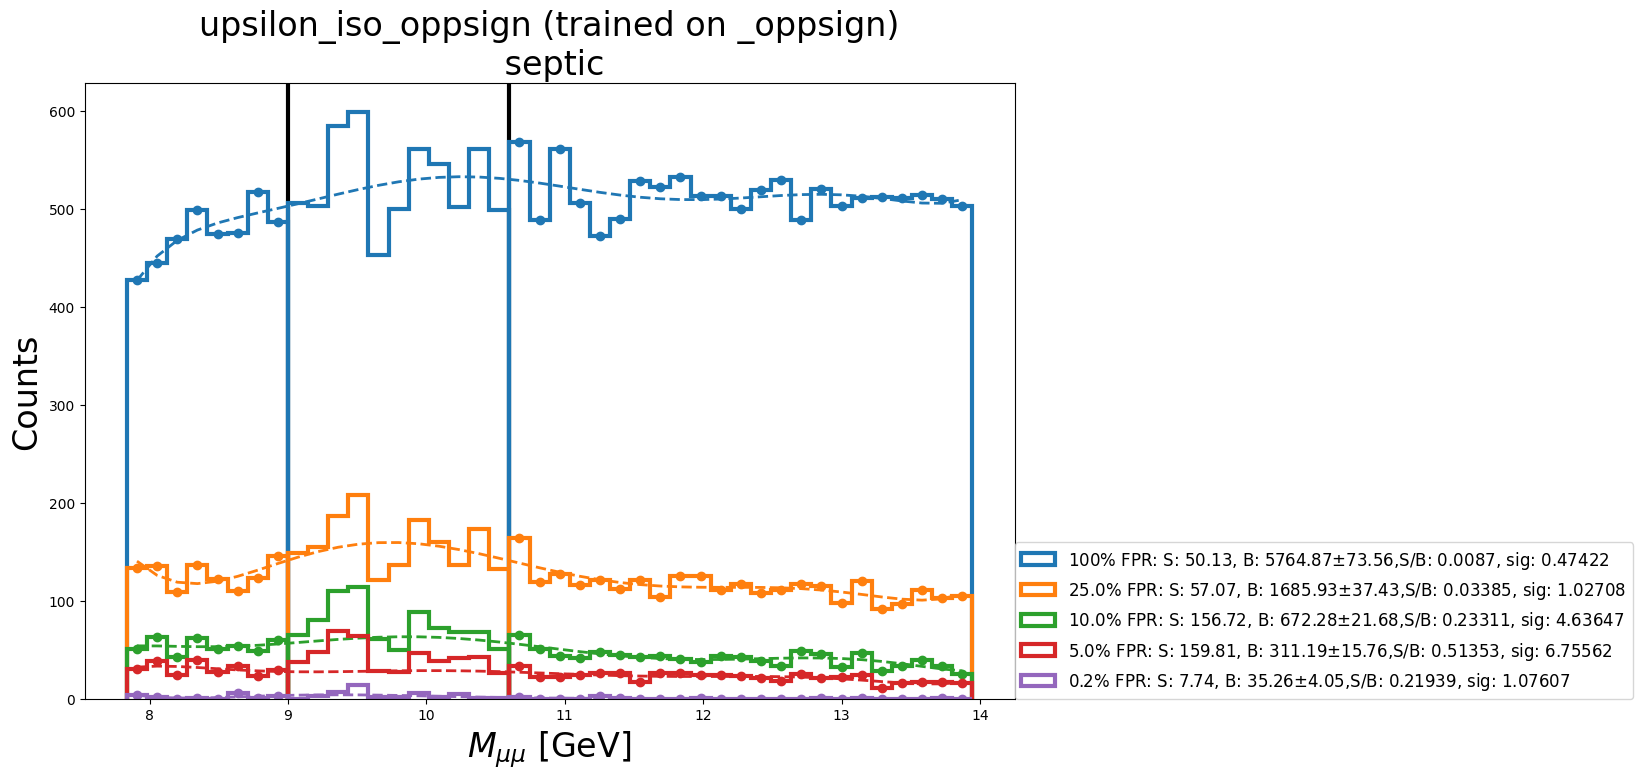

In [10]:

pseudo_e_to_plot= 0


"""
PLOT HISTOGRAM ON SMALL TEST SET
"""

fit_type = "cubic"

fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n cubic", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n quintic", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n septic", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()


[[11.24455166]
 [10.43734549]
 [14.60284902]
 ...
 [13.04253668]
 [11.19973569]
 [14.34485238]]

[[11.32457356]
 [12.07706356]
 [14.06891818]
 ...
 [ 8.02391057]
 [13.02412889]
 [ 9.56346995]]

[[12.07706356]
 [12.85375502]
 [13.75556937]
 ...
 [12.3328724 ]
 [13.02412889]
 [ 9.56346995]]

[[12.07706356]
 [12.85375502]
 [13.11204718]
 [13.65306375]
 [13.23003476]
 [14.26767823]
 [10.09719466]
 [14.86517795]
 [ 9.84513851]
 [ 9.95761585]
 [10.05210678]
 [12.28202248]
 [ 9.34496487]
 [14.90834617]
 [ 9.53176197]
 [ 8.94069585]
 [ 8.38886443]
 [14.93056854]
 [10.66704646]
 [ 9.24841598]
 [ 8.47362802]
 [10.02556511]
 [10.80901328]
 [ 8.04844663]
 [12.01871777]
 [12.00324441]
 [10.8678541 ]
 [ 9.19137865]
 [12.55942634]
 [12.43035794]
 [ 8.61056695]
 [11.1871767 ]
 [10.0801782 ]
 [ 8.87776836]
 [11.92689609]
 [11.74944973]
 [ 8.68660074]
 [11.38166049]
 [ 9.18655014]
 [11.66793155]
 [ 9.69811344]
 [14.67574784]
 [14.11901846]
 [ 9.40764525]
 [11.99544144]
 [13.95071885]
 [ 9.46904661]
 [14

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


[[12.07706356]
 [12.85375502]
 [13.75556937]
 ...
 [12.3328724 ]
 [13.02412889]
 [ 9.56346995]]

[[12.07706356]
 [12.85375502]
 [13.11204718]
 [13.65306375]
 [13.23003476]
 [14.26767823]
 [10.09719466]
 [14.86517795]
 [ 9.84513851]
 [ 9.95761585]
 [10.05210678]
 [12.28202248]
 [ 9.34496487]
 [14.90834617]
 [ 9.53176197]
 [ 8.94069585]
 [ 8.38886443]
 [14.93056854]
 [10.66704646]
 [ 9.24841598]
 [ 8.47362802]
 [10.02556511]
 [10.80901328]
 [ 8.04844663]
 [12.01871777]
 [12.00324441]
 [10.8678541 ]
 [ 9.19137865]
 [12.55942634]
 [12.43035794]
 [ 8.61056695]
 [11.1871767 ]
 [10.0801782 ]
 [ 8.87776836]
 [11.92689609]
 [11.74944973]
 [ 8.68660074]
 [11.38166049]
 [ 9.18655014]
 [11.66793155]
 [ 9.69811344]
 [14.67574784]
 [14.11901846]
 [ 9.40764525]
 [11.99544144]
 [13.95071885]
 [ 9.46904661]
 [14.51507665]
 [ 8.88743886]
 [11.44793318]
 [ 9.16377258]
 [ 7.93214647]
 [ 9.94206806]
 [11.53765298]
 [11.85946751]
 [10.89538764]
 [10.41131965]
 [ 9.3975335 ]
 [ 9.89283366]
 [10.95129112]
 [ 

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


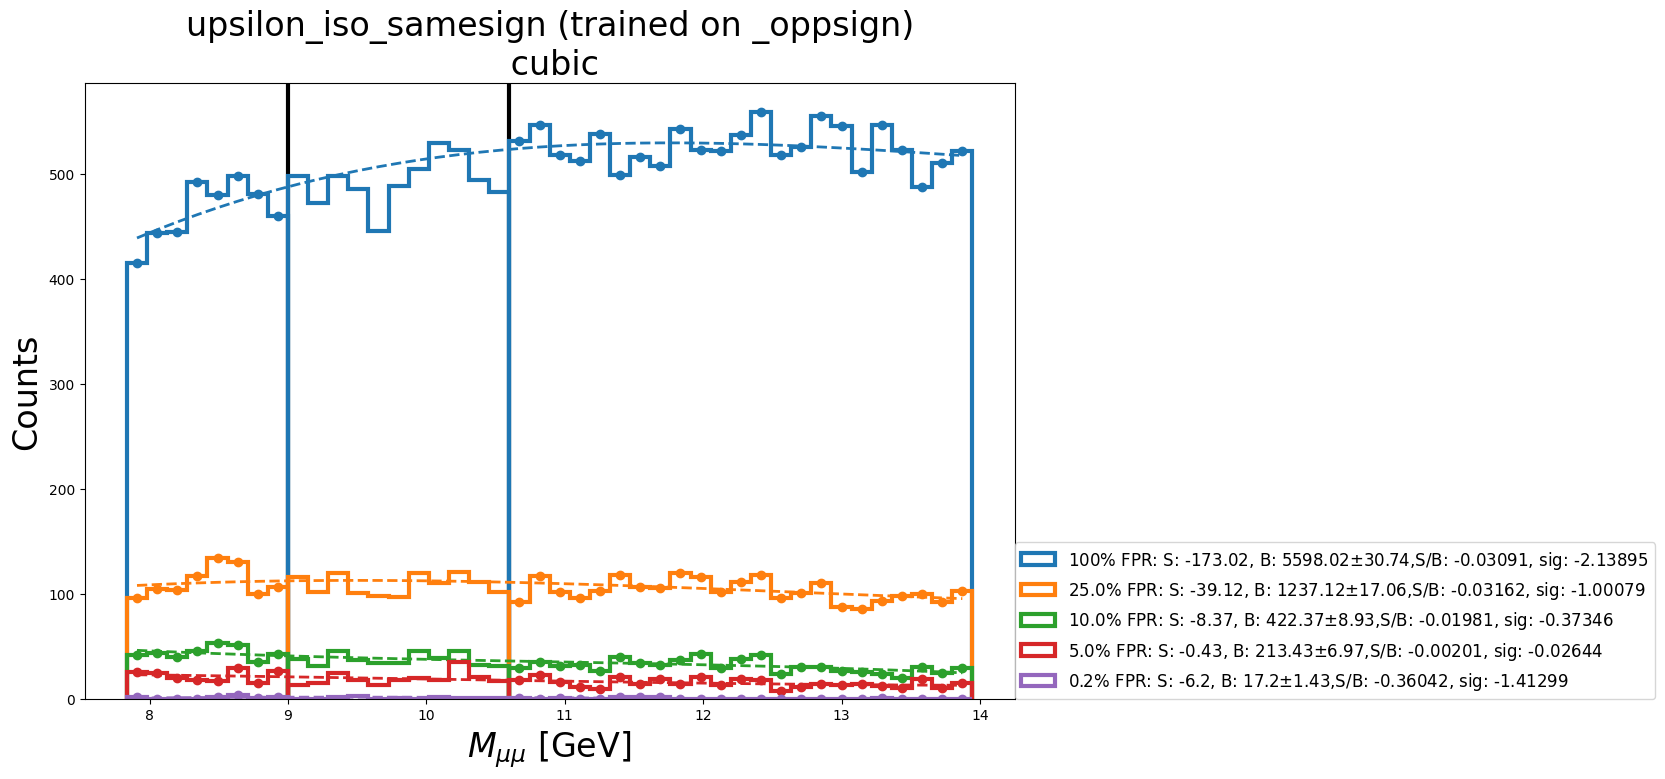

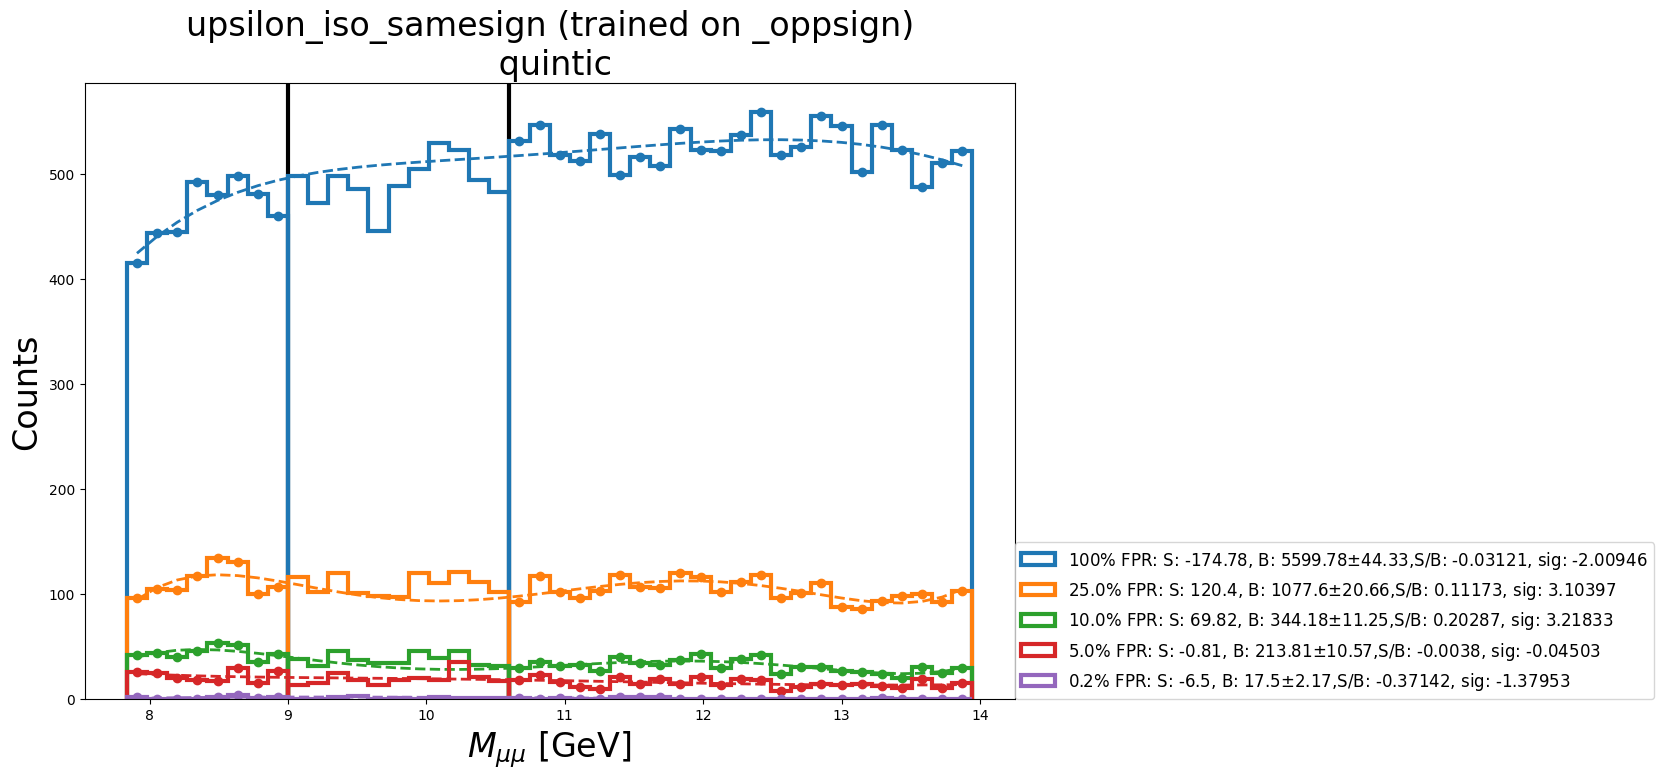

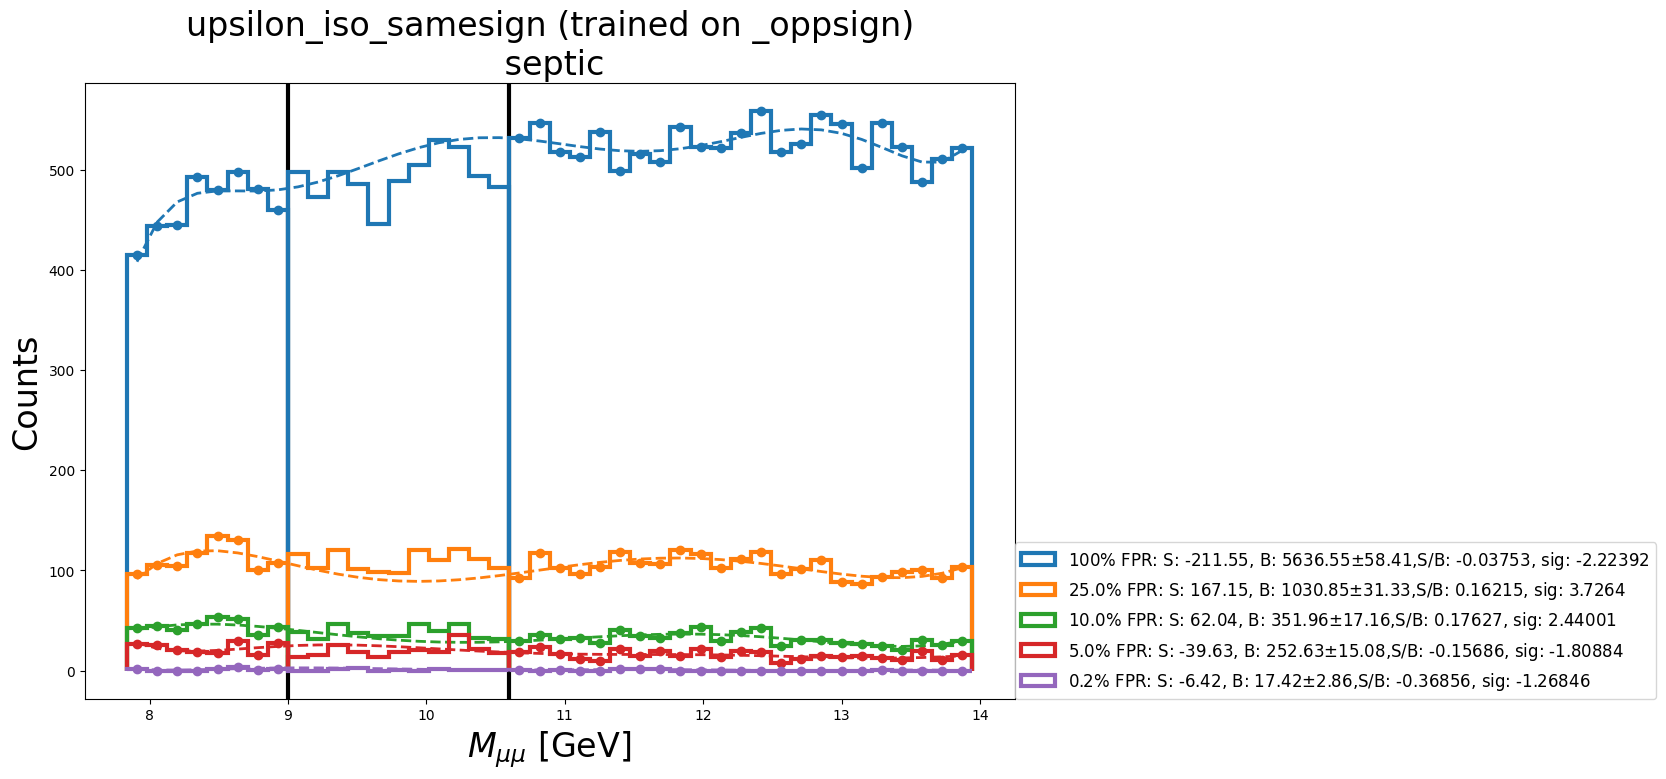

In [11]:

"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""

fit_type = "cubic"
fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n cubic"
                          ,SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n quintic",
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n septic",
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()




[[14.05376229]
 [10.3256702 ]
 [13.13557719]
 ...
 [ 7.91024766]
 [10.02507876]
 [13.21916094]]

[[14.96609485]
 [ 9.34416008]
 [10.86745738]
 ...
 [11.19658092]
 [10.02507876]
 [13.21916094]]

[[14.96609485]
 [ 9.34416008]
 [ 8.36426541]
 ...
 [ 8.80049977]
 [10.13990776]
 [10.02507876]]

[[ 9.34416008]
 [ 8.36426541]
 [13.001728  ]
 ...
 [11.67949676]
 [ 9.97601502]
 [ 8.80049977]]

[[11.01703264]
 [ 9.33351612]
 [ 9.67595203]
 ...
 [ 9.35920528]
 [ 8.50217529]
 [ 9.99174495]]

[[14.05376229]
 [10.3256702 ]
 [13.13557719]
 ...
 [ 7.91024766]
 [10.02507876]
 [13.21916094]]

[[14.96609485]
 [ 9.34416008]
 [10.86745738]
 ...
 [11.19658092]
 [10.02507876]
 [13.21916094]]

[[14.96609485]
 [ 9.34416008]
 [ 8.36426541]
 ...
 [ 8.80049977]
 [10.13990776]
 [10.02507876]]

[[ 9.34416008]
 [ 8.36426541]
 [13.001728  ]
 ...
 [11.67949676]
 [ 9.97601502]
 [ 8.80049977]]

[[11.01703264]
 [ 9.33351612]
 [ 9.67595203]
 ...
 [ 9.35920528]
 [ 8.50217529]
 [ 9.99174495]]

[[14.05376229]
 [10.3256702 ]


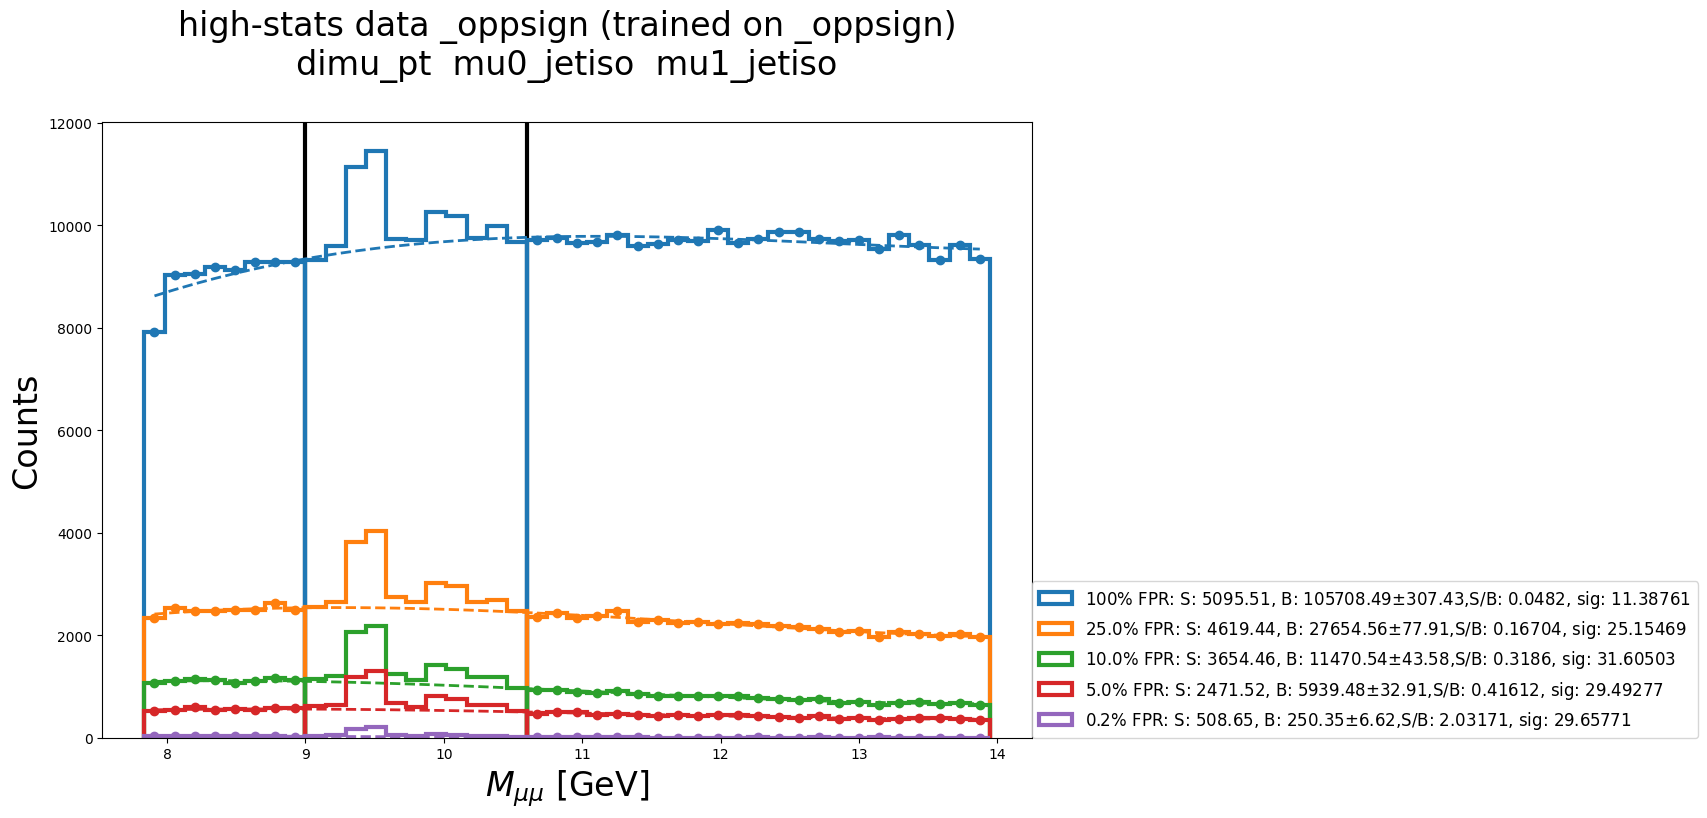

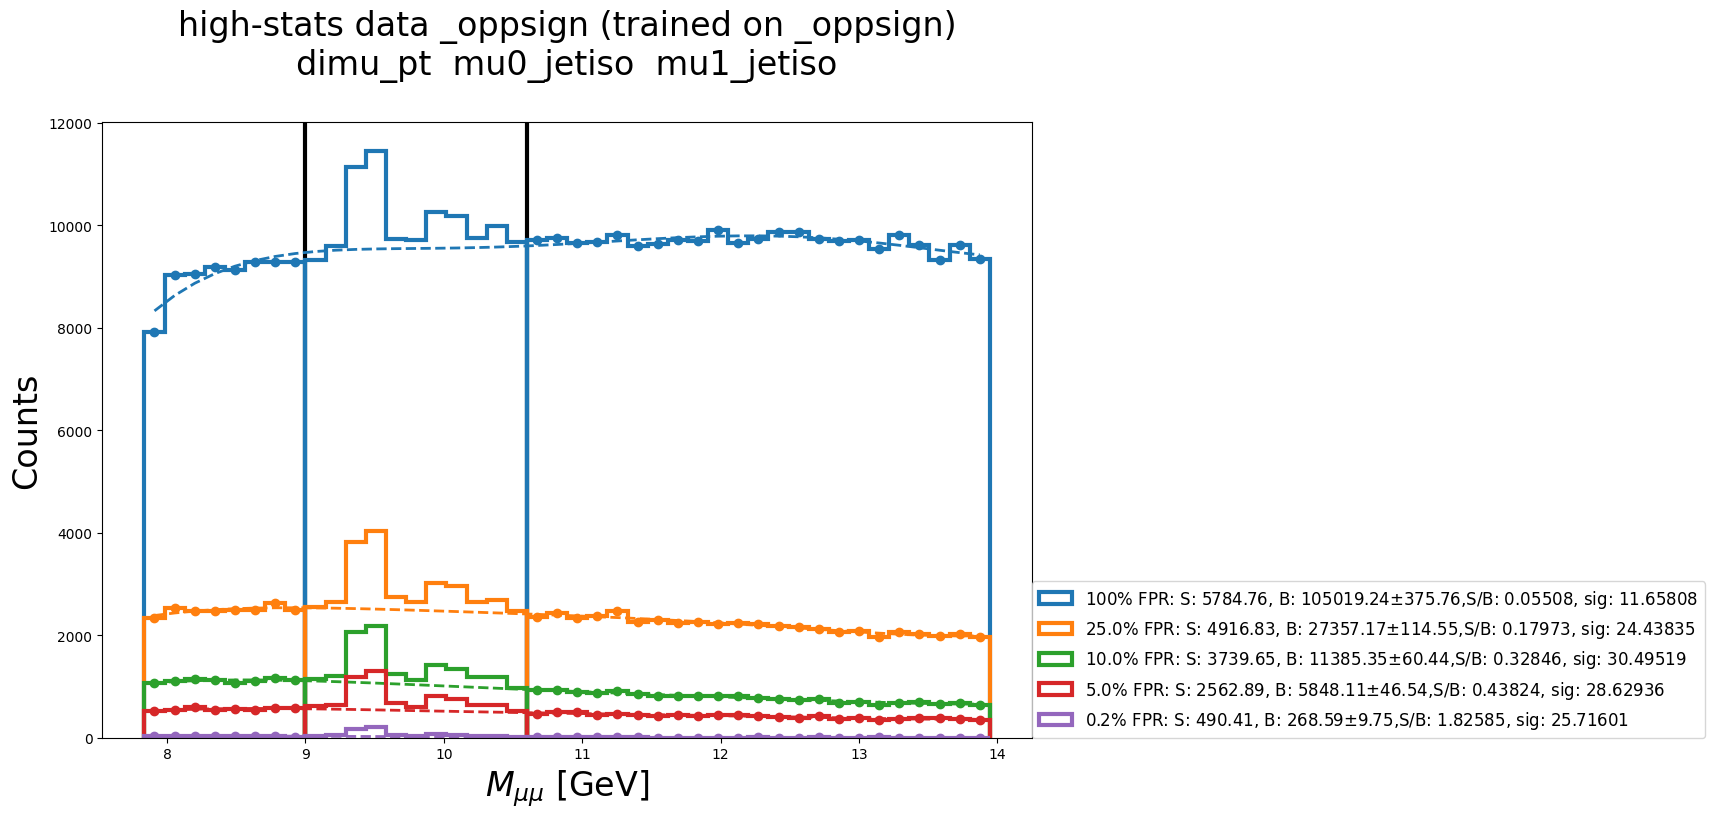

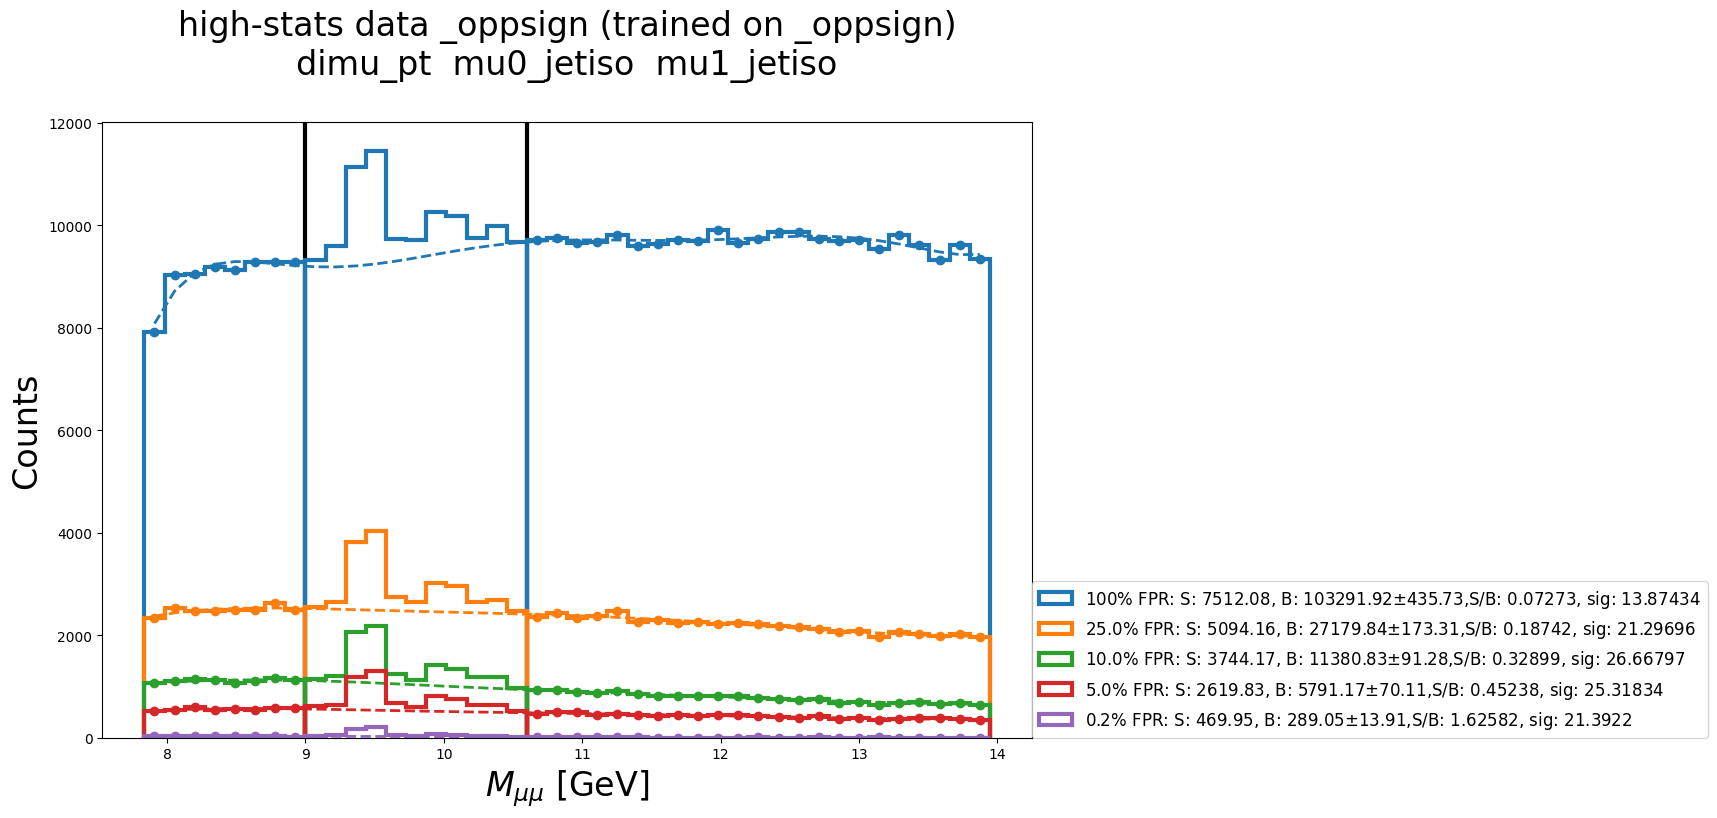

In [12]:

"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
fit_type = "cubic"
fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()



[[11.3317814 ]
 [14.5229939 ]
 [13.63021373]
 ...
 [14.38988579]
 [10.65120309]
 [14.74106798]]

[[14.5229939 ]
 [13.63021373]
 [12.50357058]
 ...
 [11.94474315]
 [11.41173553]
 [11.32943442]]

[[12.76450543]
 [11.80834485]
 [ 9.93345673]
 ...
 [ 8.05521378]
 [11.41173553]
 [11.32943442]]

[[12.07884406]
 [11.83064079]
 [11.9089098 ]
 ...
 [11.16836932]
 [12.74181657]
 [11.41173553]]

[[ 8.01507759]
 [ 8.26478669]
 [ 9.77946845]
 ...
 [12.36405087]
 [ 8.7445763 ]
 [ 8.03617285]]

[[11.3317814 ]
 [14.5229939 ]
 [13.63021373]
 ...
 [14.38988579]
 [10.65120309]
 [14.74106798]]

[[14.5229939 ]
 [13.63021373]
 [12.50357058]
 ...
 [11.94474315]
 [11.41173553]
 [11.32943442]]

[[12.76450543]
 [11.80834485]
 [ 9.93345673]
 ...
 [ 8.05521378]
 [11.41173553]
 [11.32943442]]

[[12.07884406]
 [11.83064079]
 [11.9089098 ]
 ...
 [11.16836932]
 [12.74181657]
 [11.41173553]]

[[ 8.01507759]
 [ 8.26478669]
 [ 9.77946845]
 ...
 [12.36405087]
 [ 8.7445763 ]
 [ 8.03617285]]

[[11.3317814 ]
 [14.5229939 ]


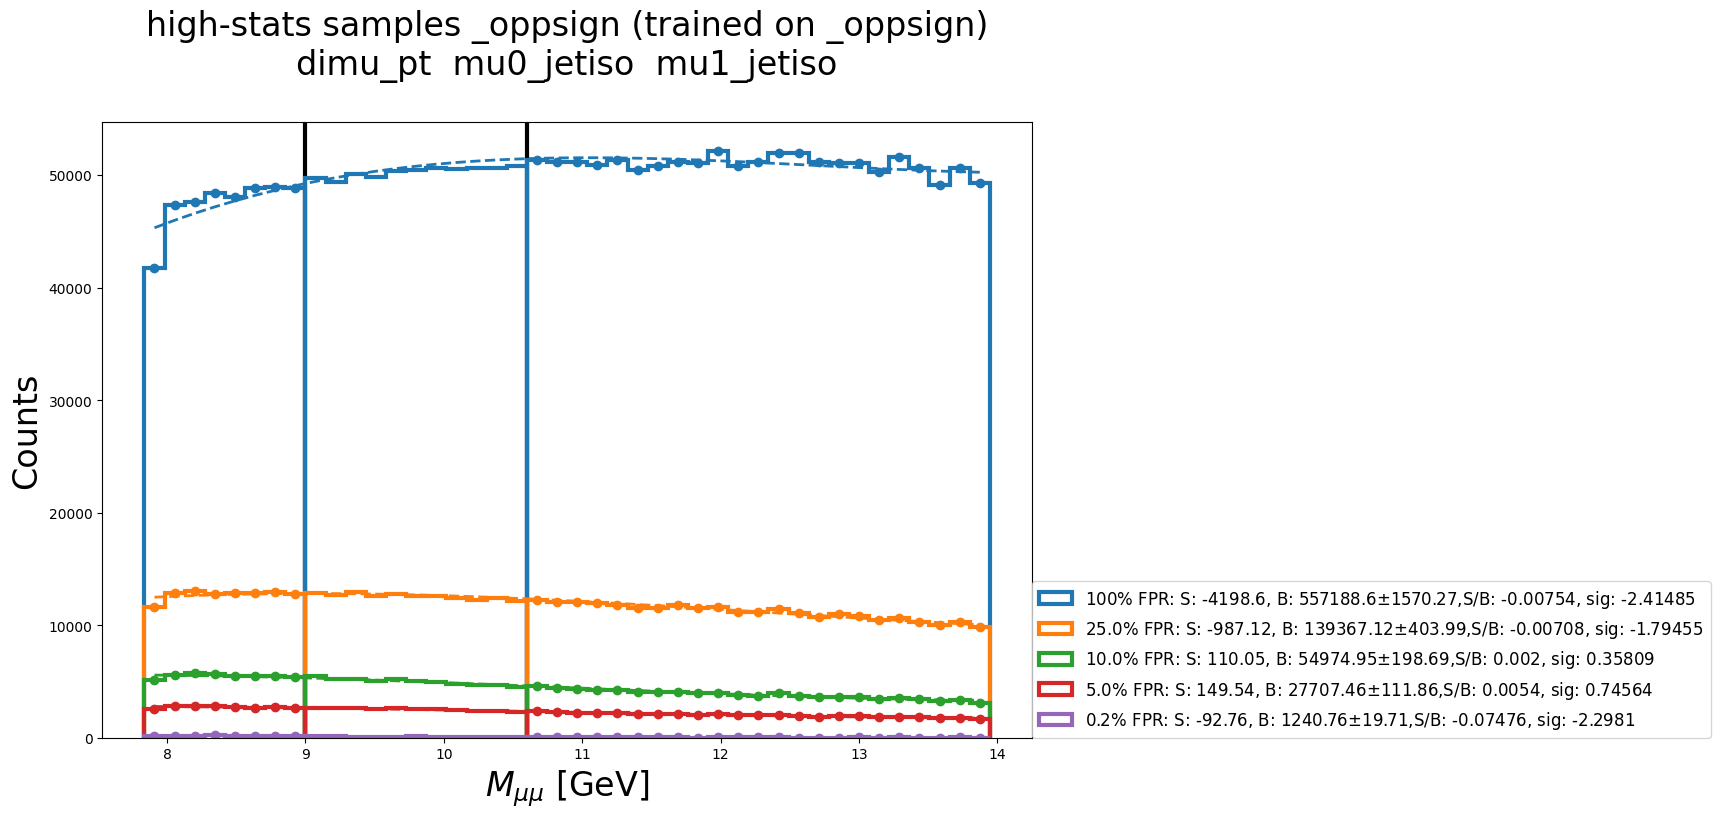

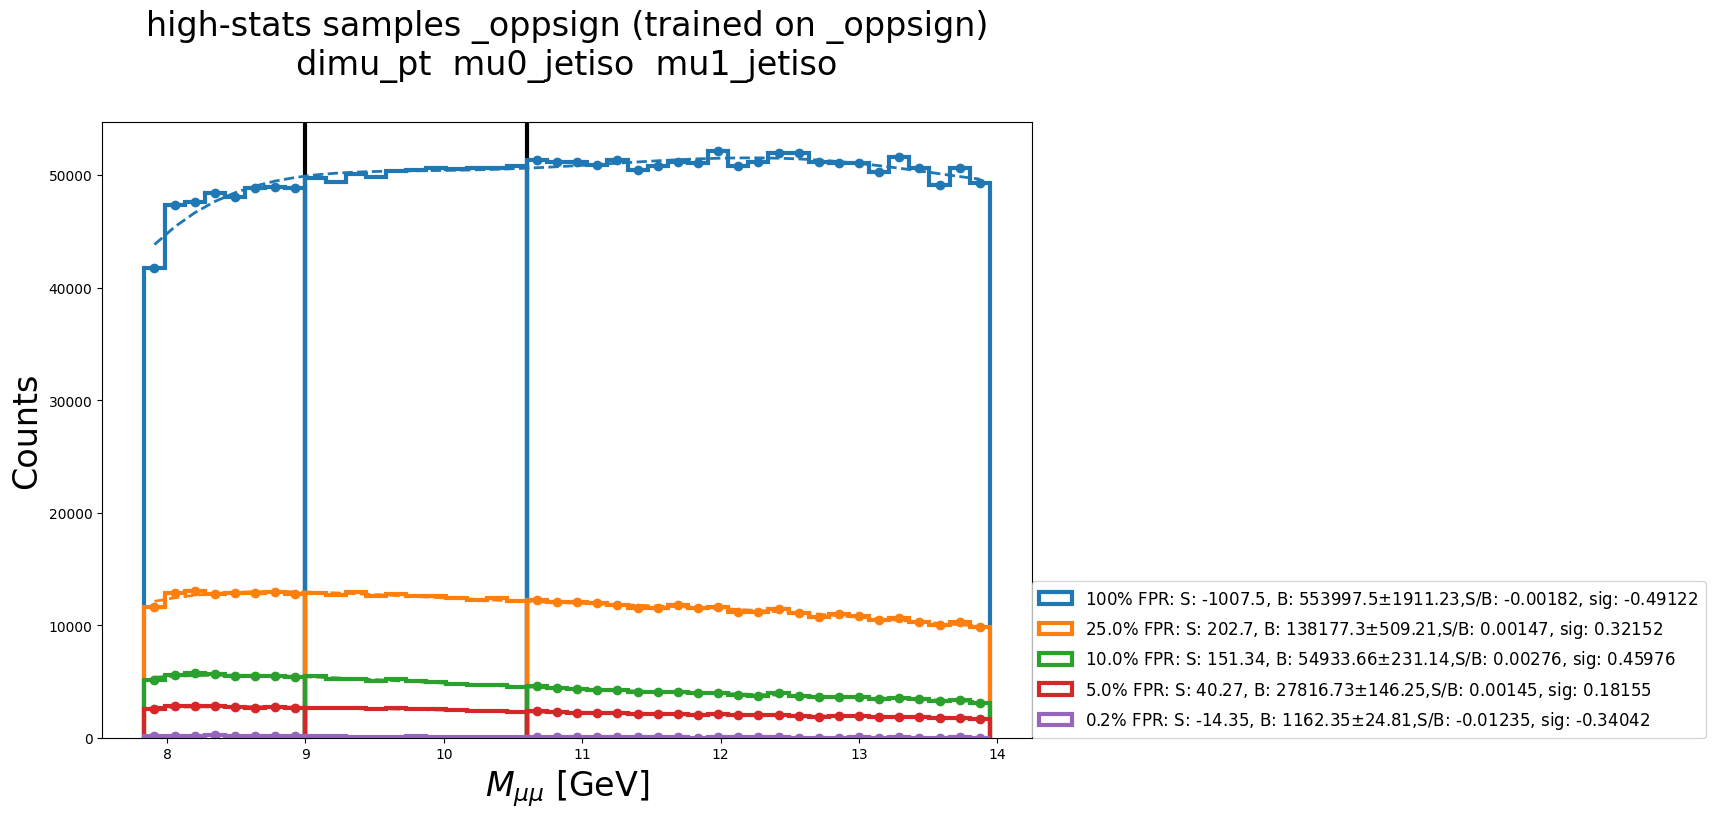

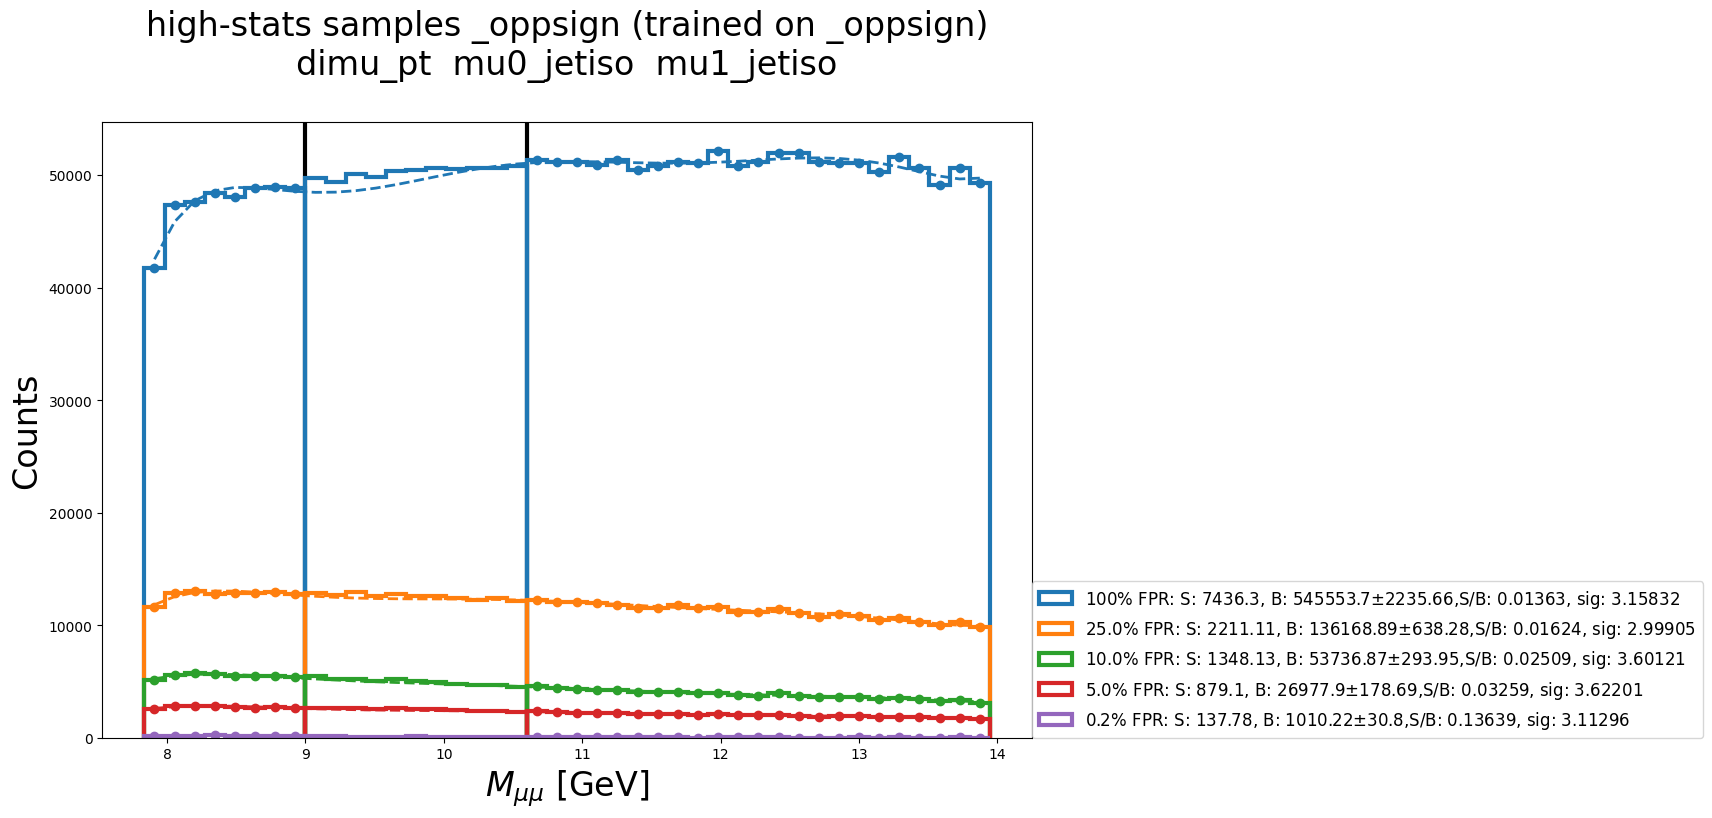

In [13]:
fit_type = "cubic"
fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()


# Classical Studies

In [14]:
print(test_data_dict["SBL"])

{'s_inj_data': {'mu0_ip3d': array([-1.1291698 ,  0.13437581, -0.6682384 , ...,  0.27586135,
       -0.4441119 , -1.0525972 ], dtype=float32), 'mu1_ip3d': array([ 0.19874589, -0.61089367, -0.7162069 , ..., -0.9330071 ,
       -0.9121817 , -0.26201722], dtype=float32), 'mu0_jetiso': array([-0.83207166, -0.31031495,  0.7459566 , ..., -0.6779407 ,
       -0.56380105, -0.23026402], dtype=float32), 'mu1_jetiso': array([-1.3299869 ,  0.3140168 ,  0.24137126, ..., -0.37562686,
        1.2863988 , -0.78069246], dtype=float32), 'mu0_eta': array([ 2.3406594 ,  0.33021837,  1.1533663 , ..., -0.19826084,
       -0.30163497,  0.42177346], dtype=float32), 'mu1_eta': array([ 2.8229454 ,  0.62748766,  1.4390717 , ...,  0.03695262,
       -0.3736185 ,  0.62078685], dtype=float32), 'mu0_pt': array([ 1.9796976,  0.2193143, -1.1687367, ...,  1.159298 ,  2.4623232,
        0.5808318], dtype=float32), 'mu1_pt': array([ 0.7513701 ,  0.6486737 , -0.86515266, ...,  1.8681109 ,
        1.4653258 ,  1.3131071 ], 

In [49]:
from helpers.plotting import feature_bins


def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 12)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    plt.figure(figsize = (12, 8))
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")   
        
 
        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        #label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))
        label_string = str(round(100*threshold, 2))+"% FPR: S: "+str(round(num_S_expected_in_SR,2))+", B: "+str(round(num_B_expected_in_SR,2))+"$\pm$"+str(np.round(B_error,2))+",S/B: "+str(round(S_over_B,5))+", sig: "+str(round(significance,5))

        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
        
        fpr_results[threshold]["S"] = round(num_S_expected_in_SR,0)
        fpr_results[threshold]["B"] = round(num_B_expected_in_SR,0)
        fpr_results[threshold]["S_over_B"] = round(S_over_B,2)
        fpr_results[threshold]["signif"] = round(significance,2)


    plt.legend(loc = (1, 0), fontsize = 12)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)

    plt.title(title, fontsize = 24)
    
    return fpr_results
    



<>:107: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1224856/21860788.py:107: SyntaxWarning: invalid escape sequence '\p'
  label_string = str(round(100*threshold, 2))+"% FPR: S: "+str(round(num_S_expected_in_SR,2))+", B: "+str(round(num_B_expected_in_SR,2))+"$\pm$"+str(np.round(B_error,2))+",S/B: "+str(round(S_over_B,5))+", sig: "+str(round(significance,5))
/tmp/ipykernel_1224856/21860788.py:124: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)


dimu_pt


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: 95.0 // 50.0 // 75.0
   num B in SR: 5720.0 // 5765.0 // 5740.0
   S/B: 0.02 // 0.01 // 0.01
   significance: 1.15 // 0.55 // 0.71

Threshold 25.0%
   cubic // quintic // septic
   num S in SR: 203.0 // 96.0 // -33.0
   num B in SR: 1789.0 // 1896.0 // 2025.0
   S/B: 0.11 // 0.05 // -0.02
   significance: 4.43 // 1.95 // -0.62

Threshold 10.0%
   cubic // quintic // septic
   num S in SR: 187.0 // 91.0 // 22.0
   num B in SR: 731.0 // 827.0 // 896.0
   S/B: 0.26 // 0.11 // 0.02
   significance: 6.42 // 2.87 // 0.63

Threshold 5.0%
   cubic // quintic // septic
   num S in SR: 142.0 // 83.0 // 47.0
   num B in SR: 323.0 // 382.0 // 418.0
   S/B: 0.44 // 0.22 // 0.11
   significance: 7.32 // 3.88 // 1.97

Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 2.0 // 1.0 // 1.0
   num B in SR: 14.0 // 15.0 // 15.0
   S/B: 0.15 // 0.05 // 0.06
   significance: 0.52 // 0.17 // 0.18

**********

mu0_jetiso


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: 96.0 // 49.0 // 48.0
   num B in SR: 5719.0 // 5766.0 // 5767.0
   S/B: 0.02 // 0.01 // 0.01
   significance: 1.16 // 0.54 // 0.45

Threshold 25.0%
   cubic // quintic // septic
   num S in SR: -126.0 // -89.0 // -30.0
   num B in SR: 1453.0 // 1416.0 // 1357.0
   S/B: -0.09 // -0.06 // -0.02
   significance: -2.97 // -1.9 // -0.54

Threshold 10.0%
   cubic // quintic // septic
   num S in SR: -45.0 // -10.0 // 91.0
   num B in SR: 581.0 // 546.0 // 445.0
   S/B: -0.08 // -0.02 // 0.21
   significance: -1.69 // -0.35 // 2.97

Threshold 5.0%
   cubic // quintic // septic
   num S in SR: -3.0 // 11.0 // 32.0
   num B in SR: 280.0 // 266.0 // 245.0
   S/B: -0.01 // 0.04 // 0.13
   significance: -0.14 // 0.59 // 1.45

Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 13.0 // 13.0 // 3.0
   num B in SR: -1.0 // -1.0 // 9.0
   S/B: -16.46 // -9.43 // 0.31
   significance: 11.87 // 7.94 // 0.69

**********

mu1_jetiso


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: 94.0 // 48.0 // 50.0
   num B in SR: 5719.0 // 5765.0 // 5763.0
   S/B: 0.02 // 0.01 // 0.01
   significance: 1.14 // 0.53 // 0.47

Threshold 25.0%
   cubic // quintic // septic
   num S in SR: -23.0 // -14.0 // 29.0
   num B in SR: 1377.0 // 1368.0 // 1325.0
   S/B: -0.02 // -0.01 // 0.02
   significance: -0.57 // -0.33 // 0.58

Threshold 10.0%
   cubic // quintic // septic
   num S in SR: -27.0 // -58.0 // -15.0
   num B in SR: 526.0 // 557.0 // 514.0
   S/B: -0.05 // -0.1 // -0.03
   significance: -1.07 // -2.17 // -0.52

Threshold 5.0%
   cubic // quintic // septic
   num S in SR: -8.0 // -0.0 // 35.0
   num B in SR: 268.0 // 260.0 // 225.0
   S/B: -0.03 // -0.0 // 0.15
   significance: -0.44 // -0.0 // 1.7

Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 5.0 // 9.0 // 2.0
   num B in SR: 5.0 // 1.0 // 8.0
   S/B: 0.85 // 8.05 // 0.3
   significance: 1.72 // 4.15 // 0.59

**********



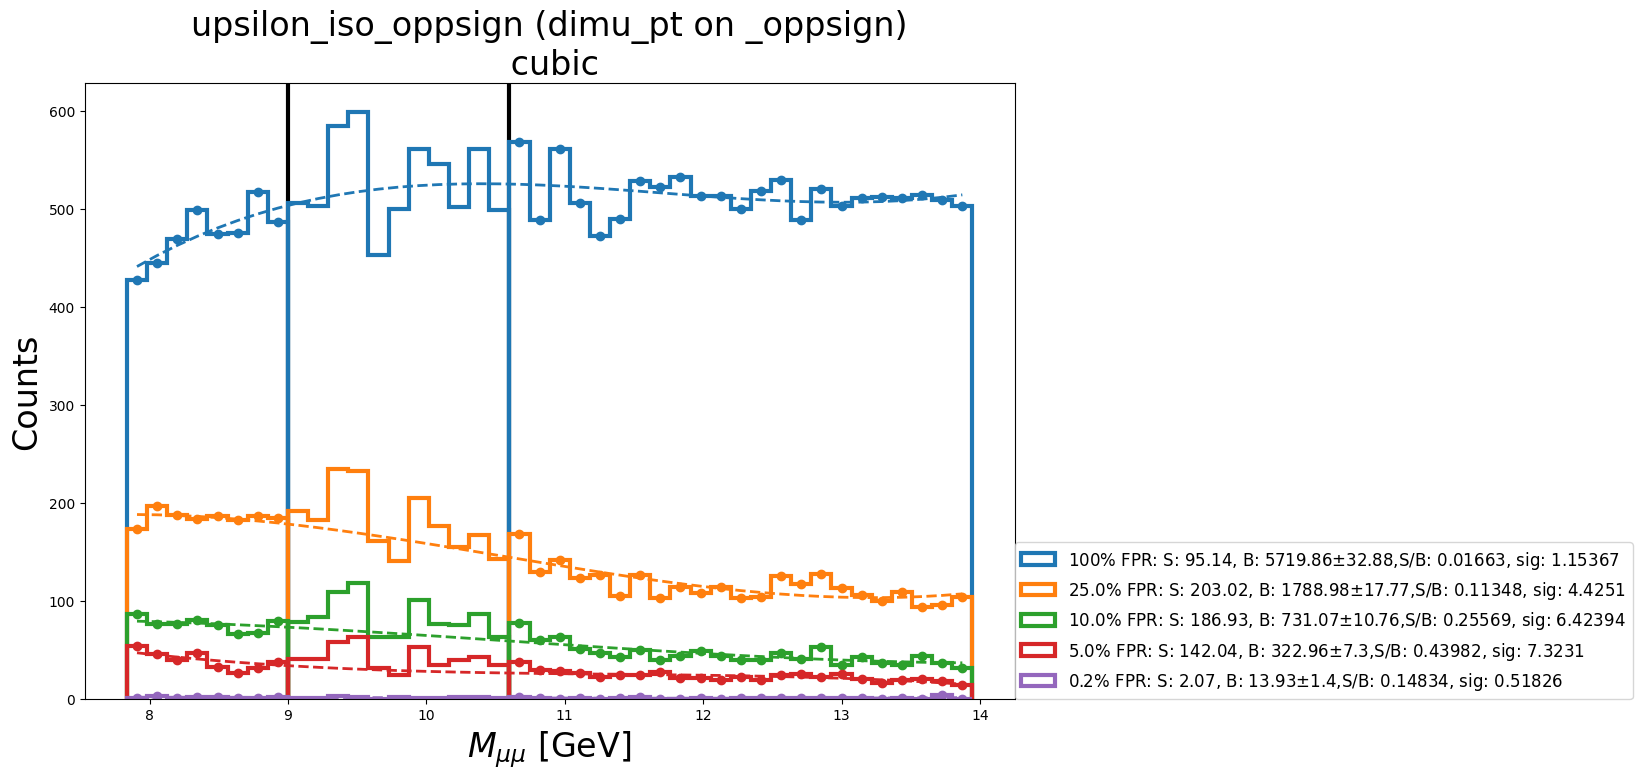

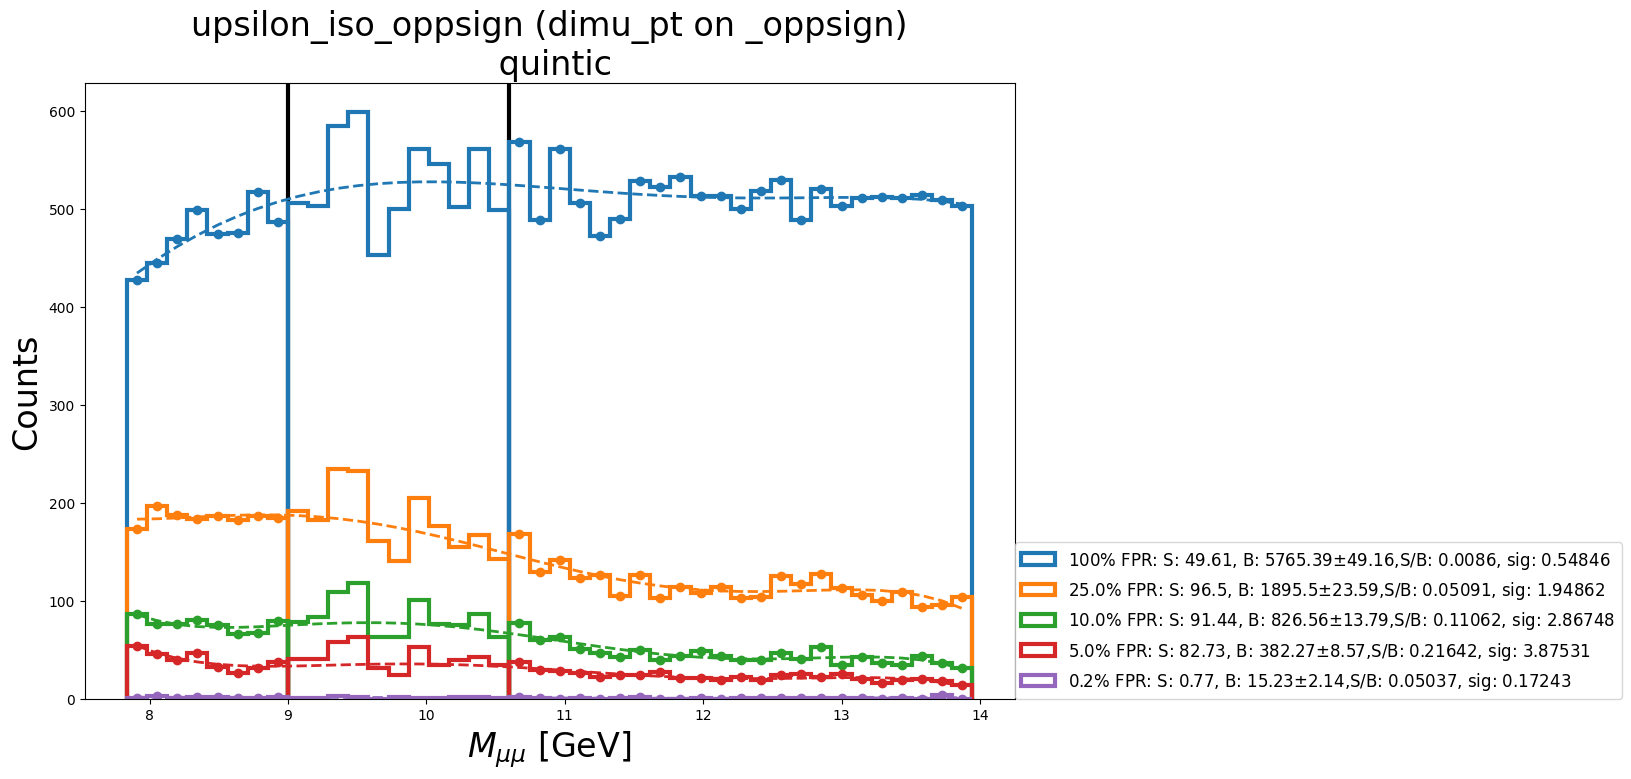

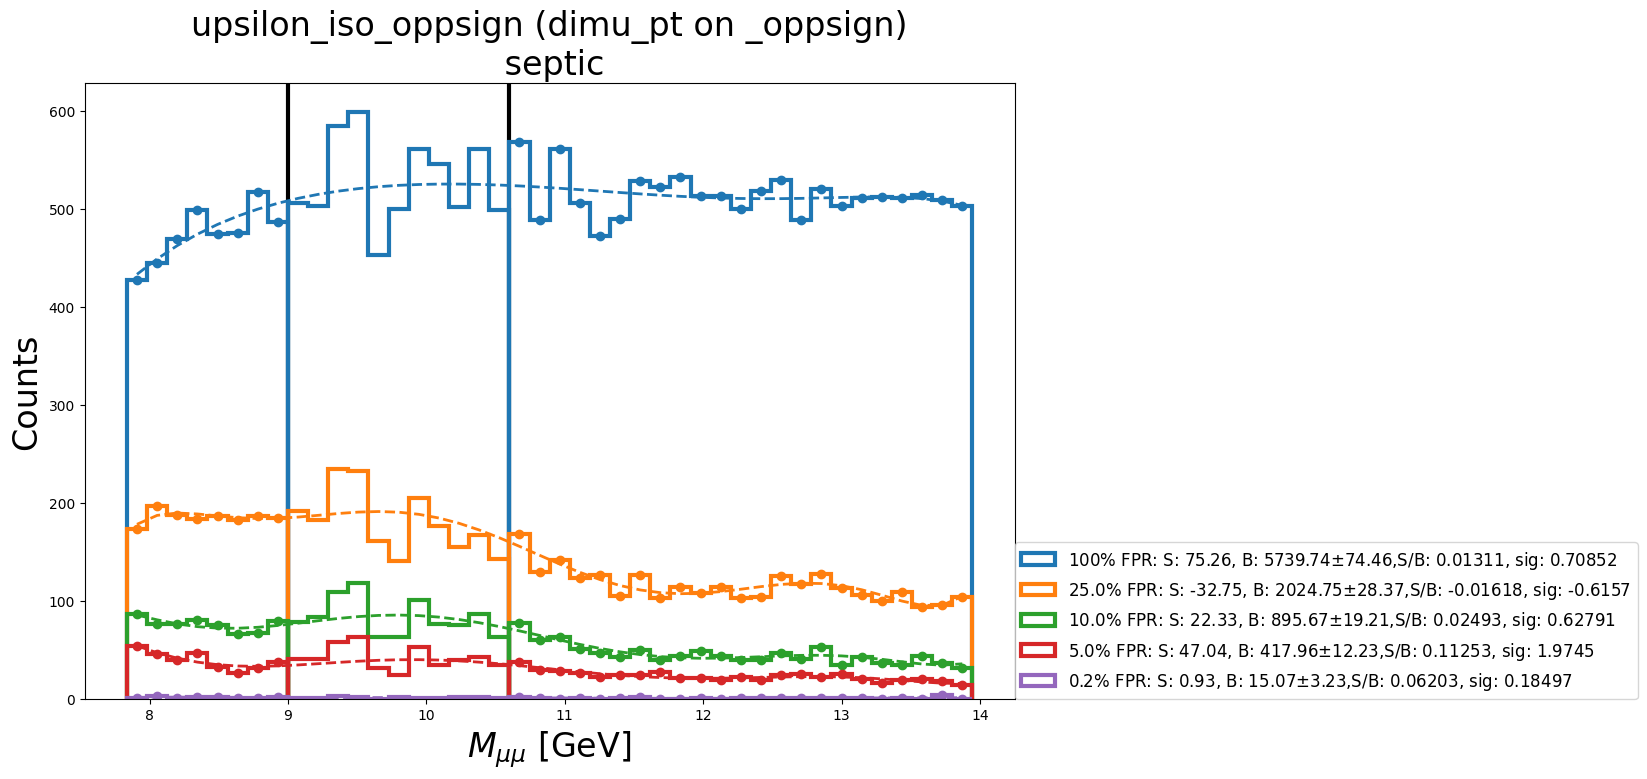

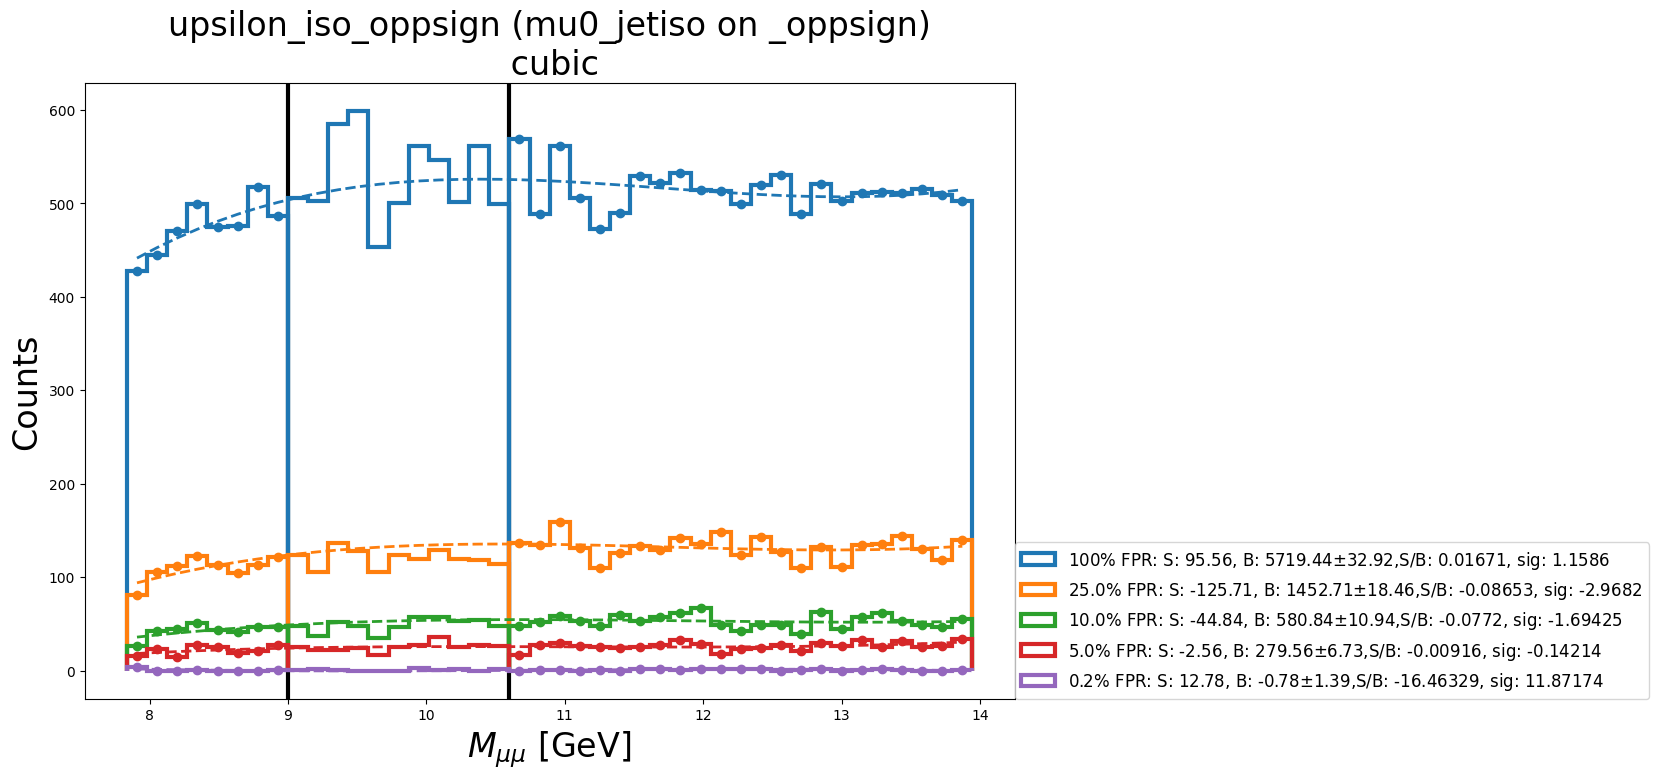

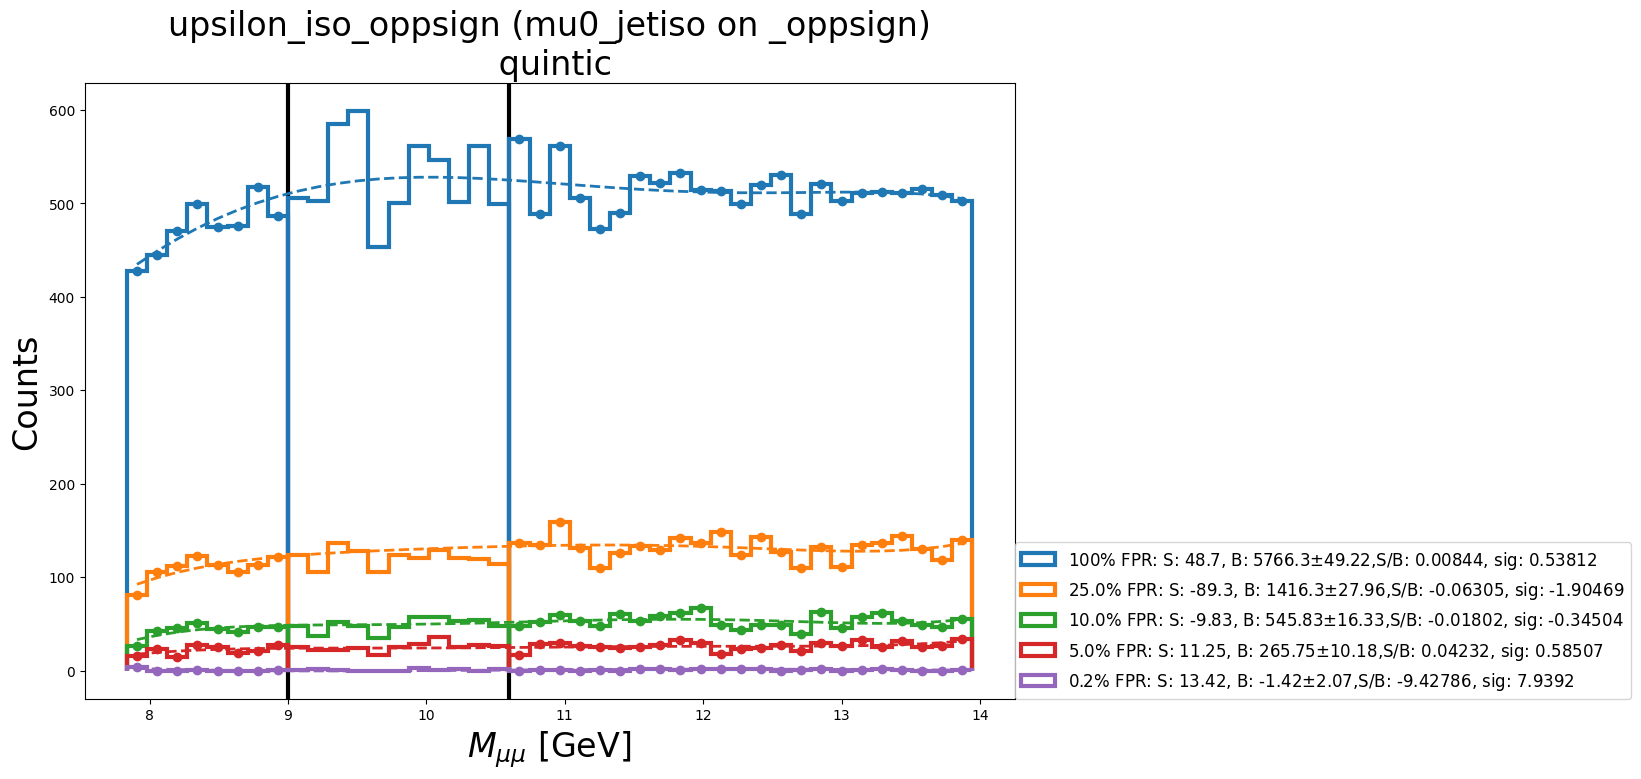

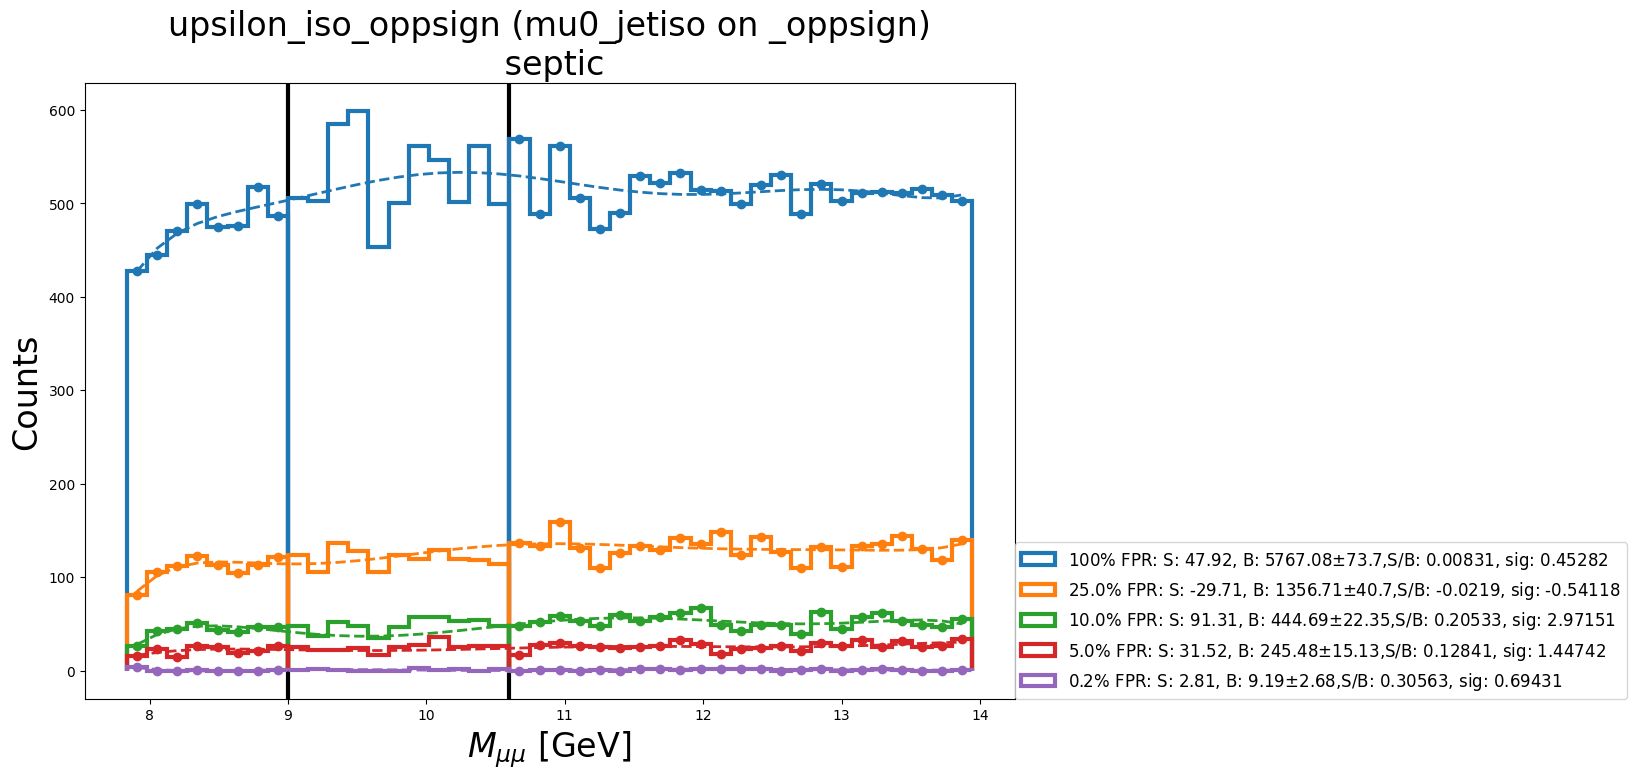

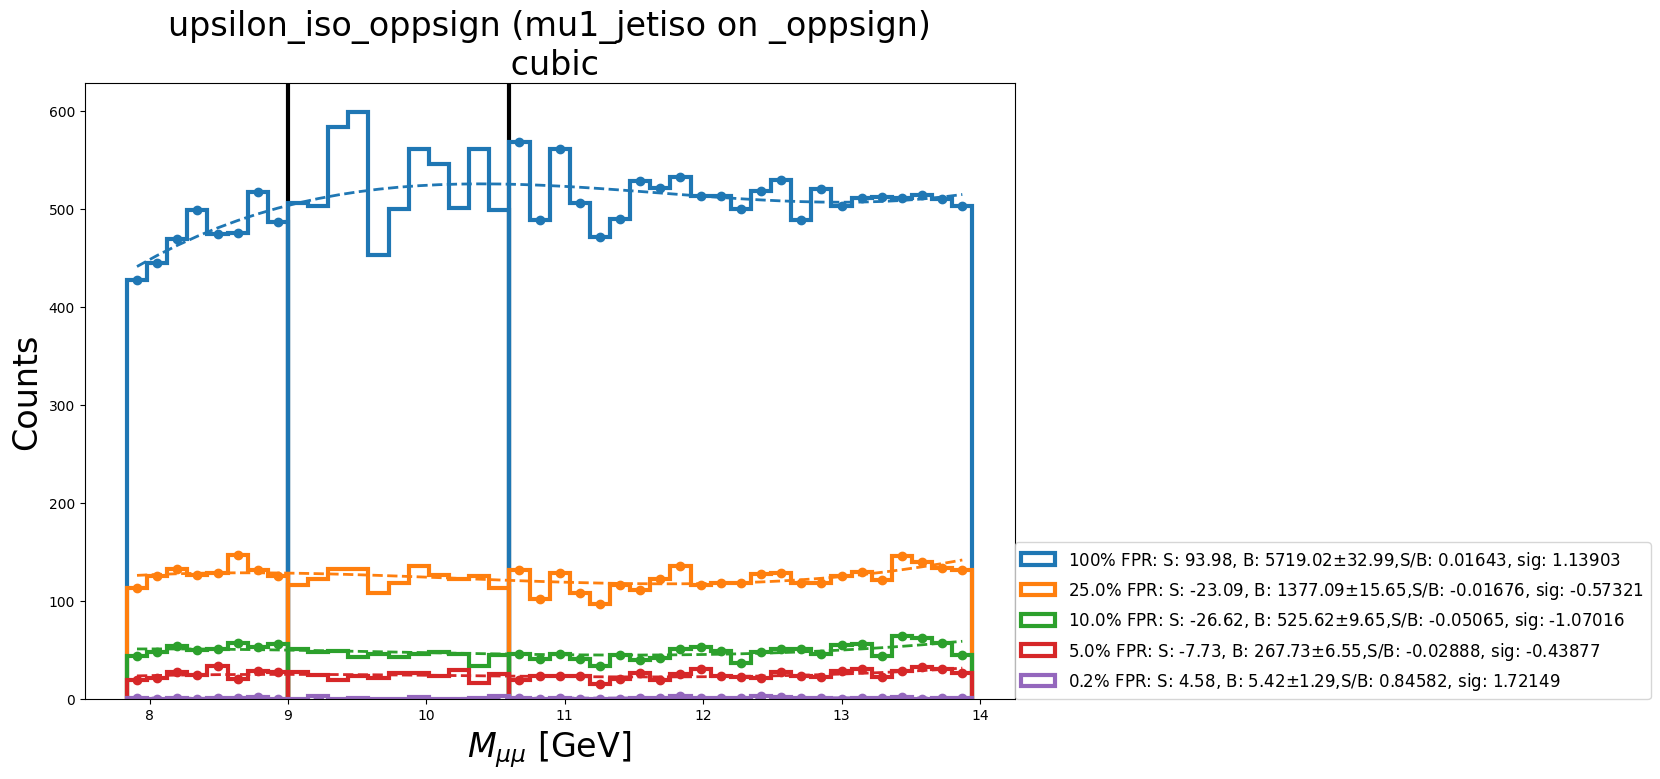

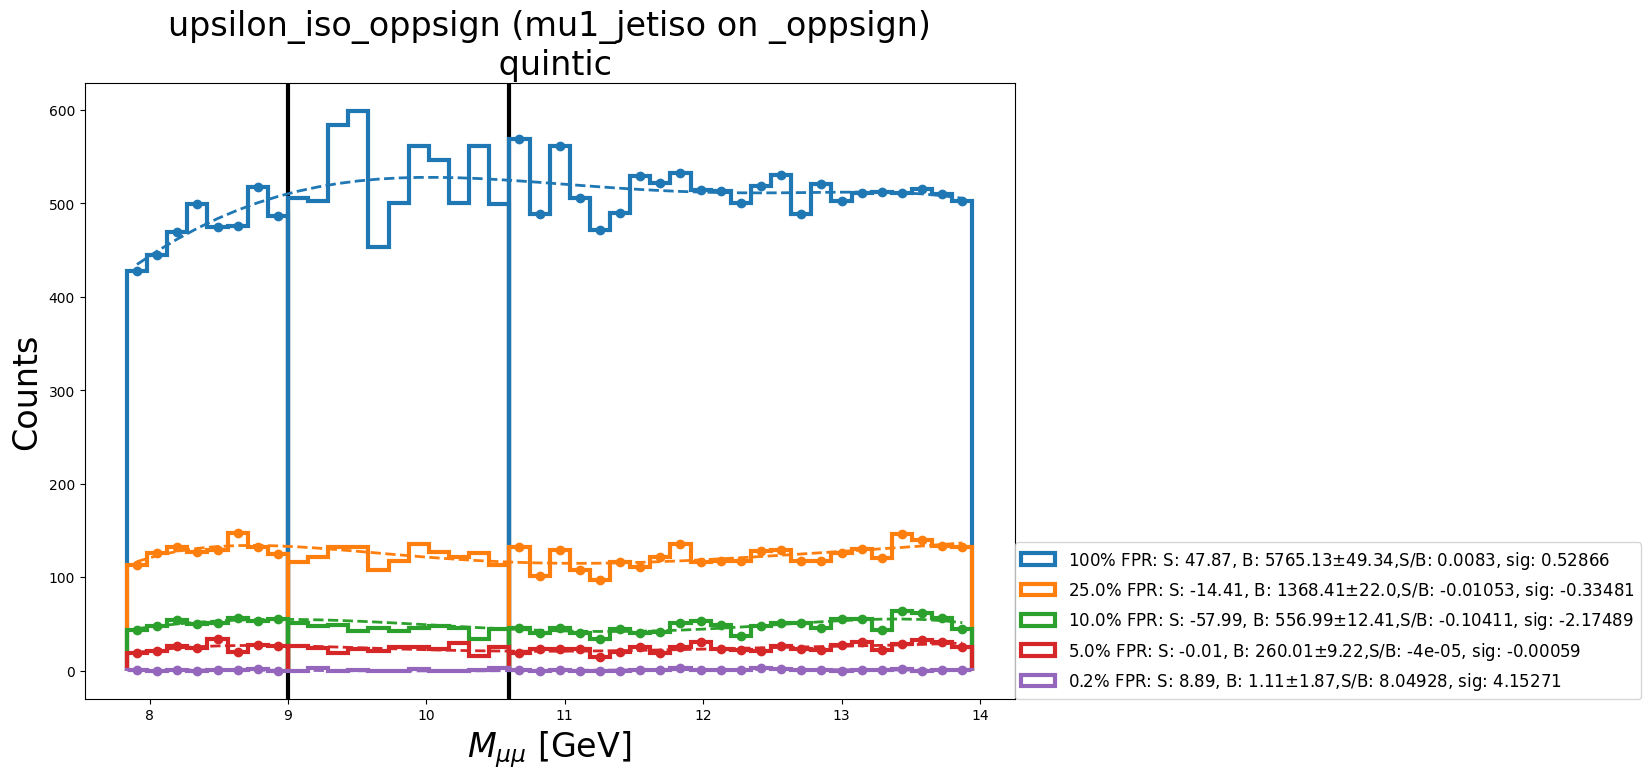

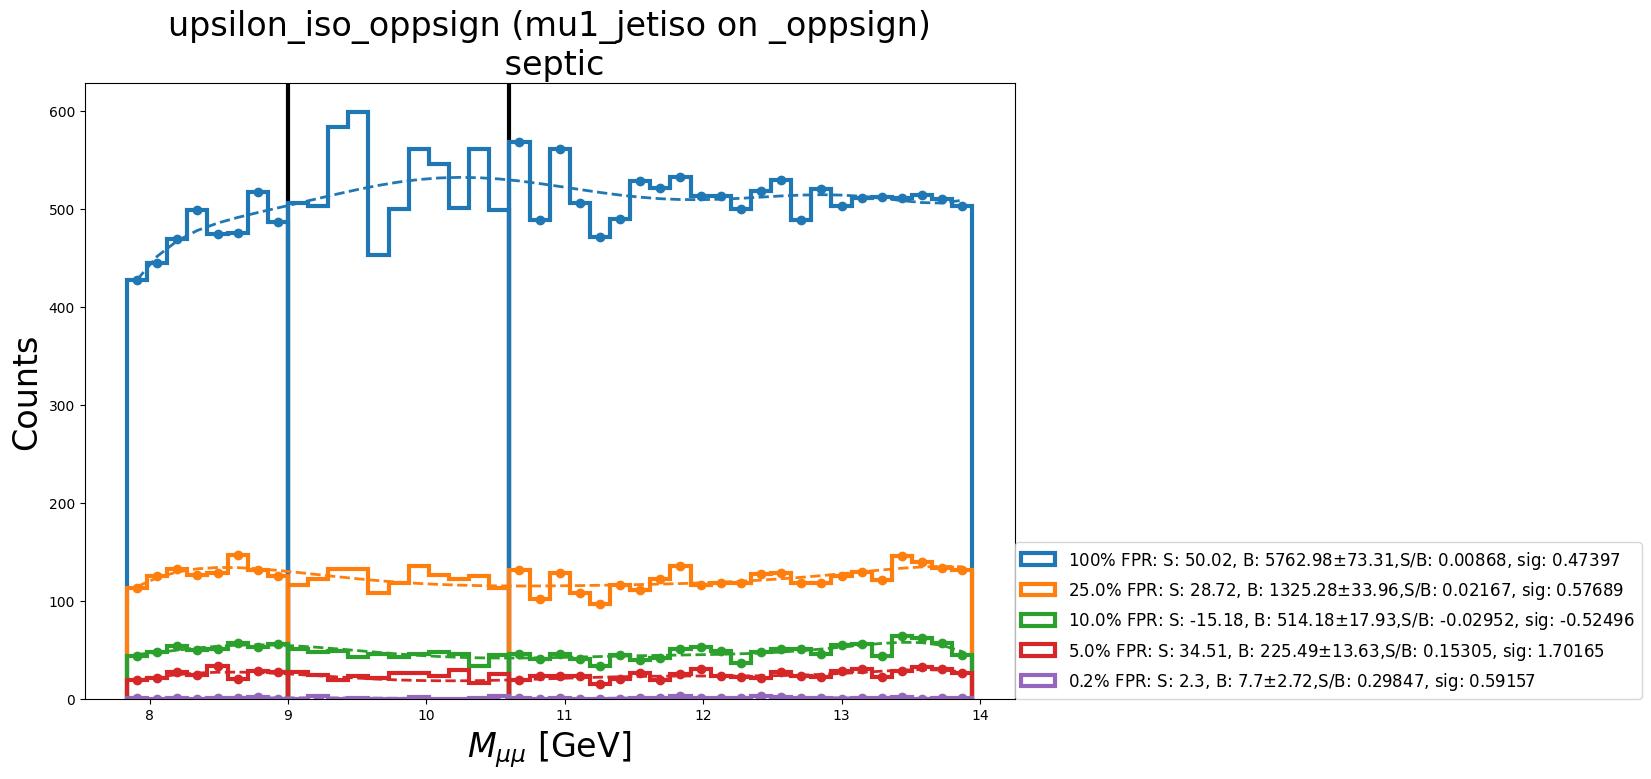

In [50]:
for feature in feature_set[:-1]:
    print(feature)
    fpr_results_cubic = plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, "cubic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n cubic", SB_left, SR_left, SR_right, SB_right)
    fpr_results_quintic = plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, "quintic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right)
    fpr_results_septic = plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, "septic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n septic", SB_left, SR_left, SR_right, SB_right)
    for f in fpr_results_septic.keys():
        print(f"Threshold {100*f}%")
        print("   cubic // quintic // septic")
        print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
        print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
        print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
        print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
        print()
    print(10*"*"+"\n")


dimu_pt


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: -180.0 // -188.0 // -234.0
   num B in SR: 5589.0 // 5597.0 // 5643.0
   S/B: -0.03 // -0.03 // -0.04
   significance: -2.22 // -2.16 // -2.46
Threshold 25.0%
   cubic // quintic // septic
   num S in SR: -20.0 // 102.0 // 140.0
   num B in SR: 1647.0 // 1525.0 // 1487.0
   S/B: -0.01 // 0.07 // 0.09
   significance: -0.43 // 2.0 // 2.25
Threshold 10.0%
   cubic // quintic // septic
   num S in SR: -29.0 // 62.0 // 98.0
   num B in SR: 695.0 // 604.0 // 568.0
   S/B: -0.04 // 0.1 // 0.17
   significance: -0.93 // 1.84 // 2.34
Threshold 5.0%
   cubic // quintic // septic
   num S in SR: -35.0 // 51.0 // 83.0
   num B in SR: 342.0 // 256.0 // 224.0
   S/B: -0.1 // 0.2 // 0.37
   significance: -1.65 // 2.36 // 3.08
Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 2.0 // 1.0 // -9.0
   num B in SR: 8.0 // 9.0 // 19.0
   S/B: 0.19 // 0.12 // -0.46
   significance: 0.46 // 0.27 // -1.43
mu0_jetiso


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: -169.0 // -166.0 // -207.0
   num B in SR: 5593.0 // 5590.0 // 5631.0
   S/B: -0.03 // -0.03 // -0.04
   significance: -2.09 // -1.92 // -2.2
Threshold 25.0%
   cubic // quintic // septic
   num S in SR: -129.0 // -126.0 // -123.0
   num B in SR: 1437.0 // 1434.0 // 1431.0
   S/B: -0.09 // -0.09 // -0.09
   significance: -3.19 // -2.89 // -2.58
Threshold 10.0%
   cubic // quintic // septic
   num S in SR: -80.0 // -29.0 // 16.0
   num B in SR: 579.0 // 528.0 // 483.0
   S/B: -0.14 // -0.05 // 0.03
   significance: -3.01 // -1.02 // 0.5
Threshold 5.0%
   cubic // quintic // septic
   num S in SR: -5.0 // -1.0 // 24.0
   num B in SR: 269.0 // 265.0 // 240.0
   S/B: -0.02 // -0.01 // 0.1
   significance: -0.29 // -0.07 // 1.13
Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 12.0 // 10.0 // 16.0
   num B in SR: 9.0 // 11.0 // 5.0
   S/B: 1.27 // 0.85 // 3.28
   significance: 3.47 // 2.38 // 4.07
mu1_jetiso


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:103: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: -173.0 // -175.0 // -212.0
   num B in SR: 5598.0 // 5600.0 // 5637.0
   S/B: -0.03 // -0.03 // -0.04
   significance: -2.14 // -2.01 // -2.22
Threshold 25.0%
   cubic // quintic // septic
   num S in SR: -68.0 // -27.0 // 2.0
   num B in SR: 1330.0 // 1289.0 // 1260.0
   S/B: -0.05 // -0.02 // 0.0
   significance: -1.78 // -0.67 // 0.06
Threshold 10.0%
   cubic // quintic // septic
   num S in SR: 22.0 // 65.0 // 68.0
   num B in SR: 472.0 // 429.0 // 426.0
   S/B: 0.05 // 0.15 // 0.16
   significance: 0.9 // 2.52 // 2.21
Threshold 5.0%
   cubic // quintic // septic
   num S in SR: -10.0 // 14.0 // 5.0
   num B in SR: 237.0 // 213.0 // 222.0
   S/B: -0.04 // 0.06 // 0.02
   significance: -0.54 // 0.7 // 0.22
Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 10.0 // 2.0 // 11.0
   num B in SR: 0.0 // 8.0 // -1.0
   S/B: 32.33 // 0.18 // -19.49
   significance: 5.53 // 0.42 // 3.27


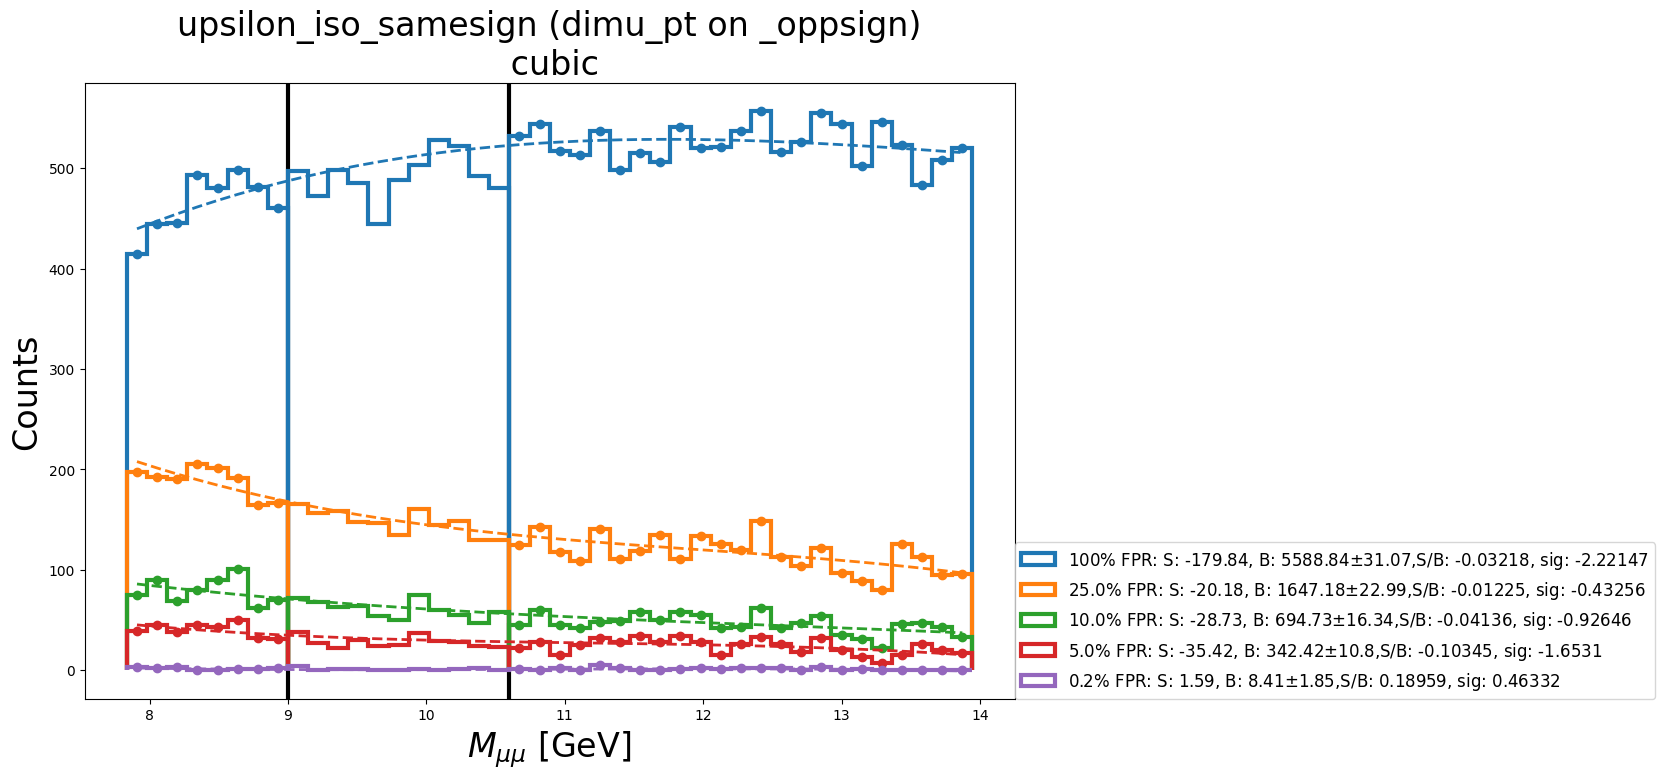

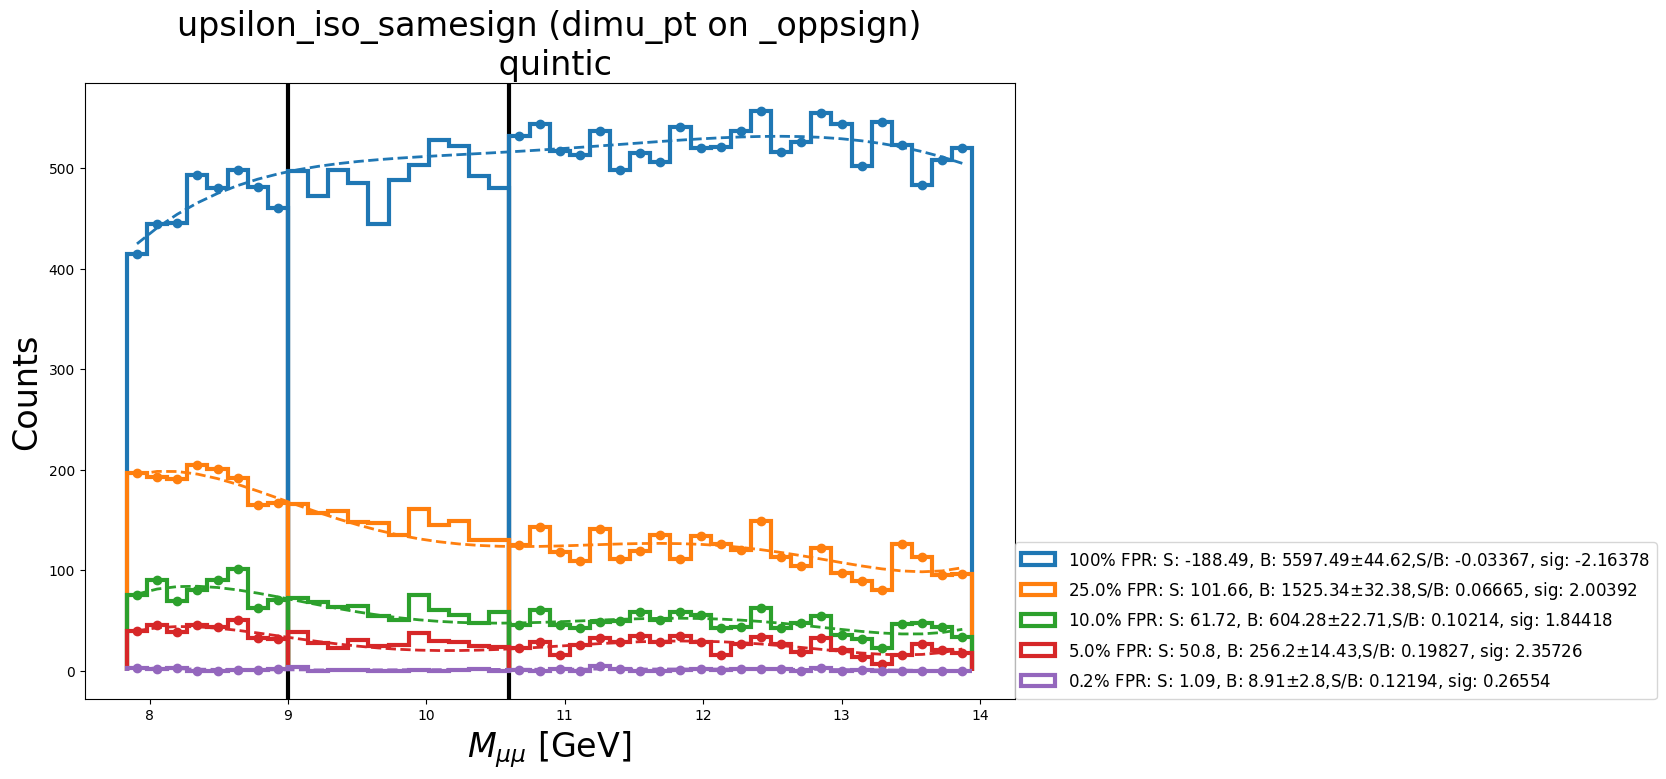

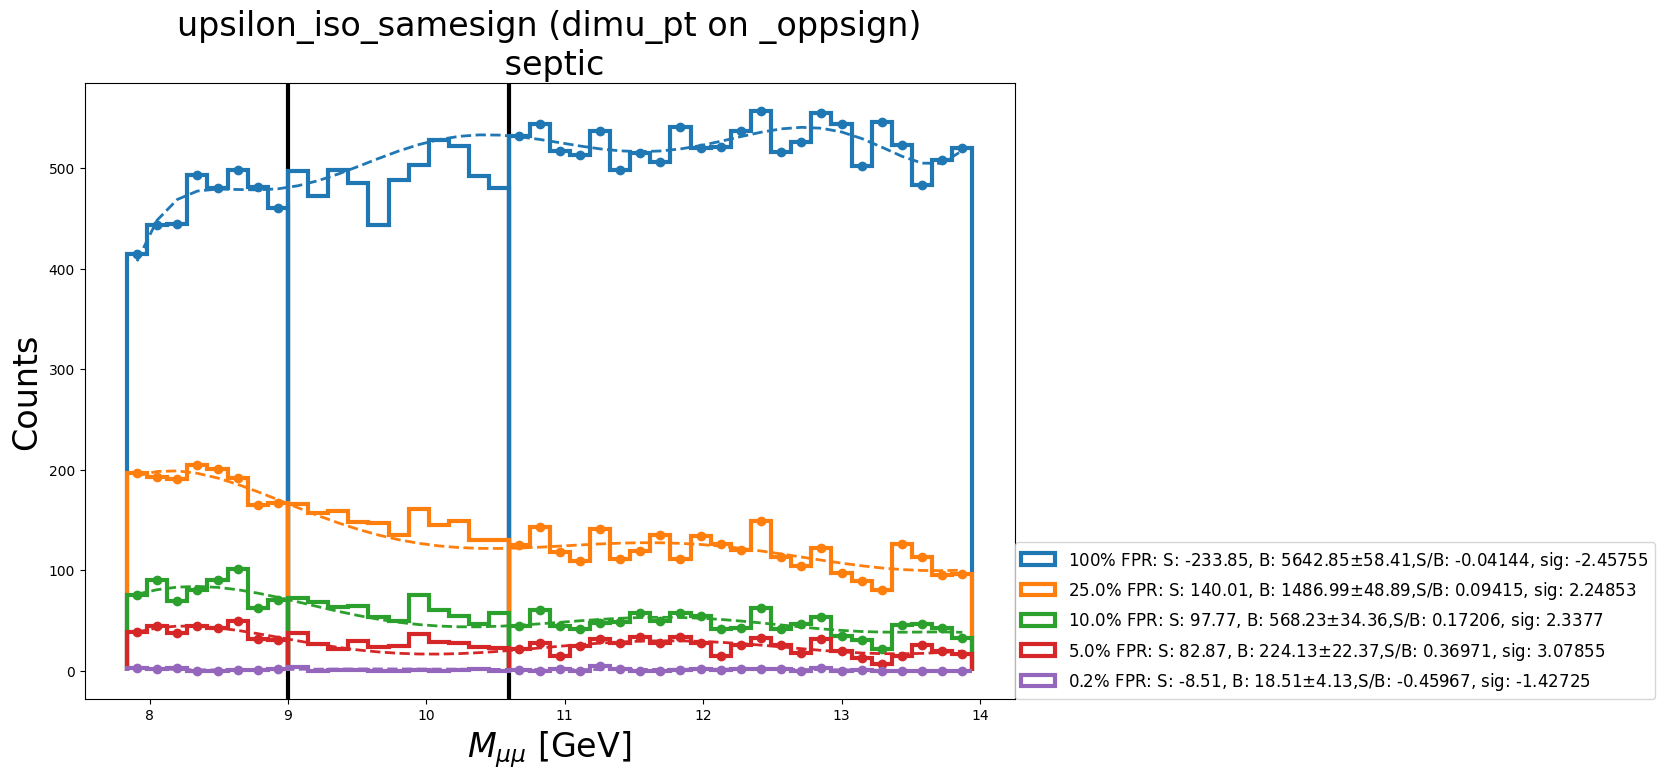

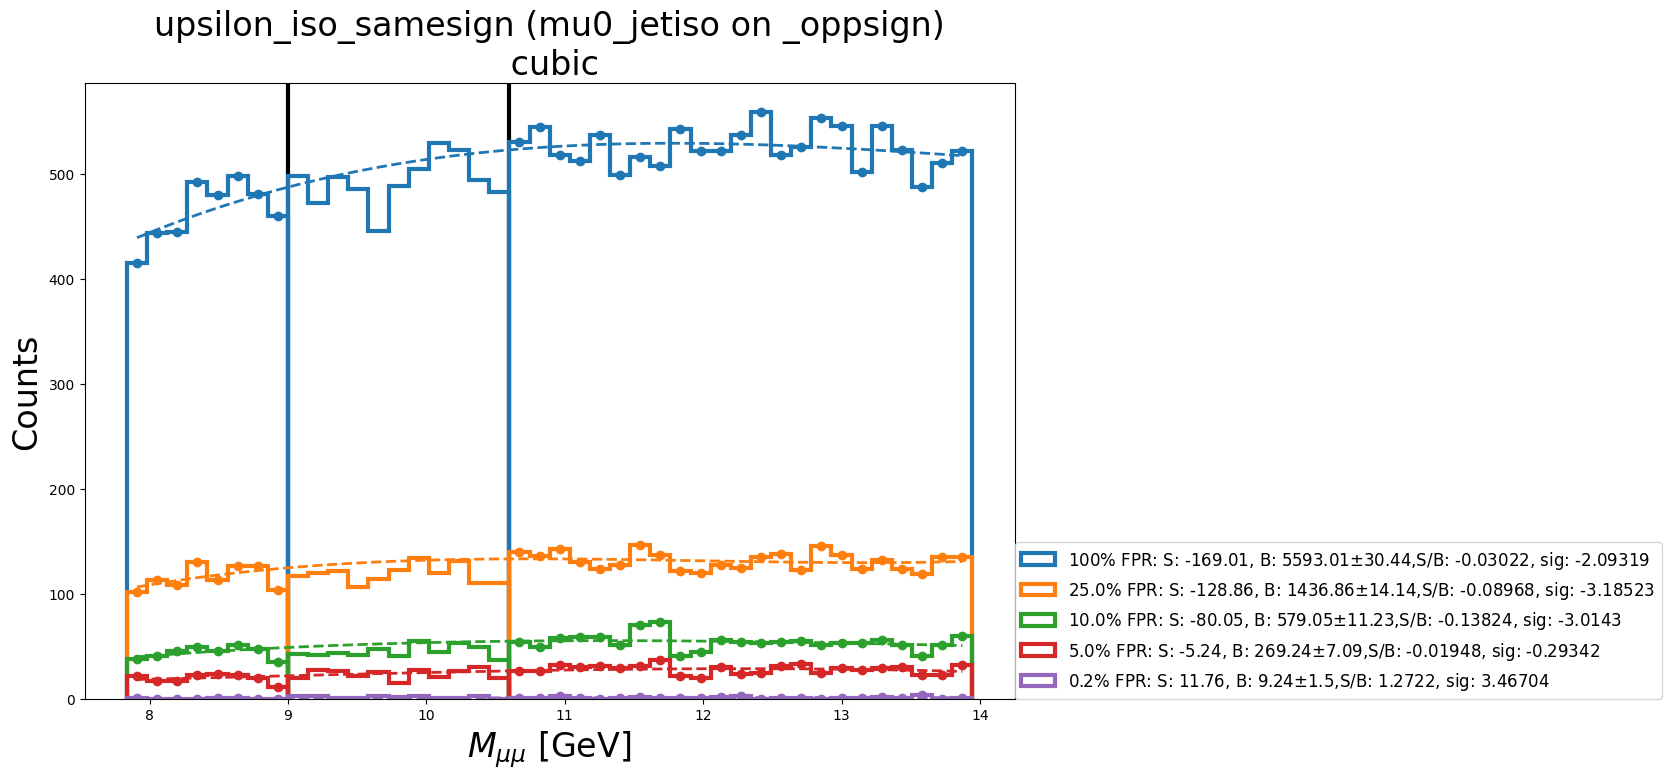

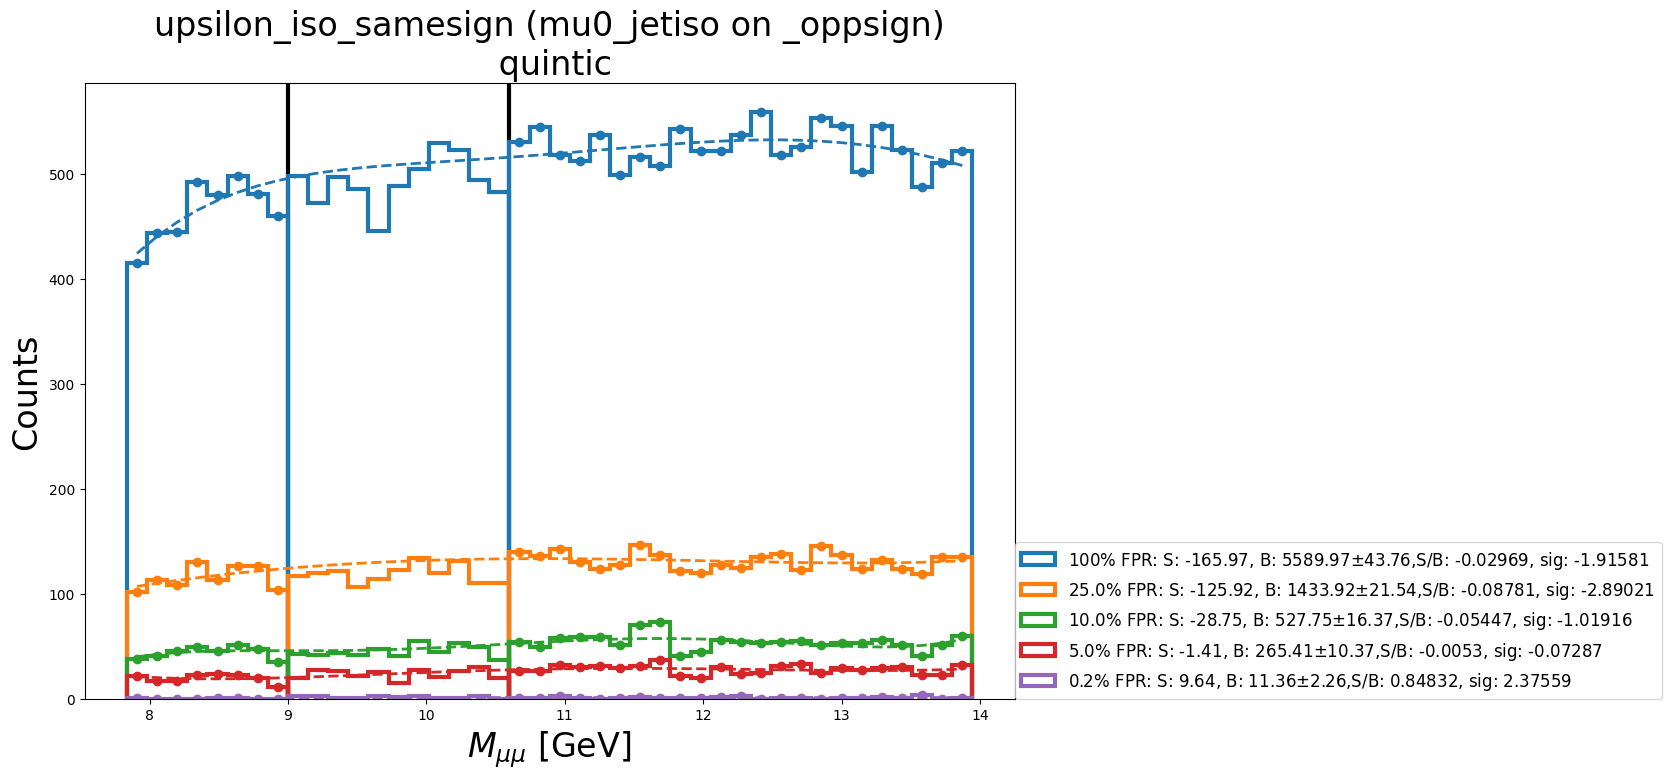

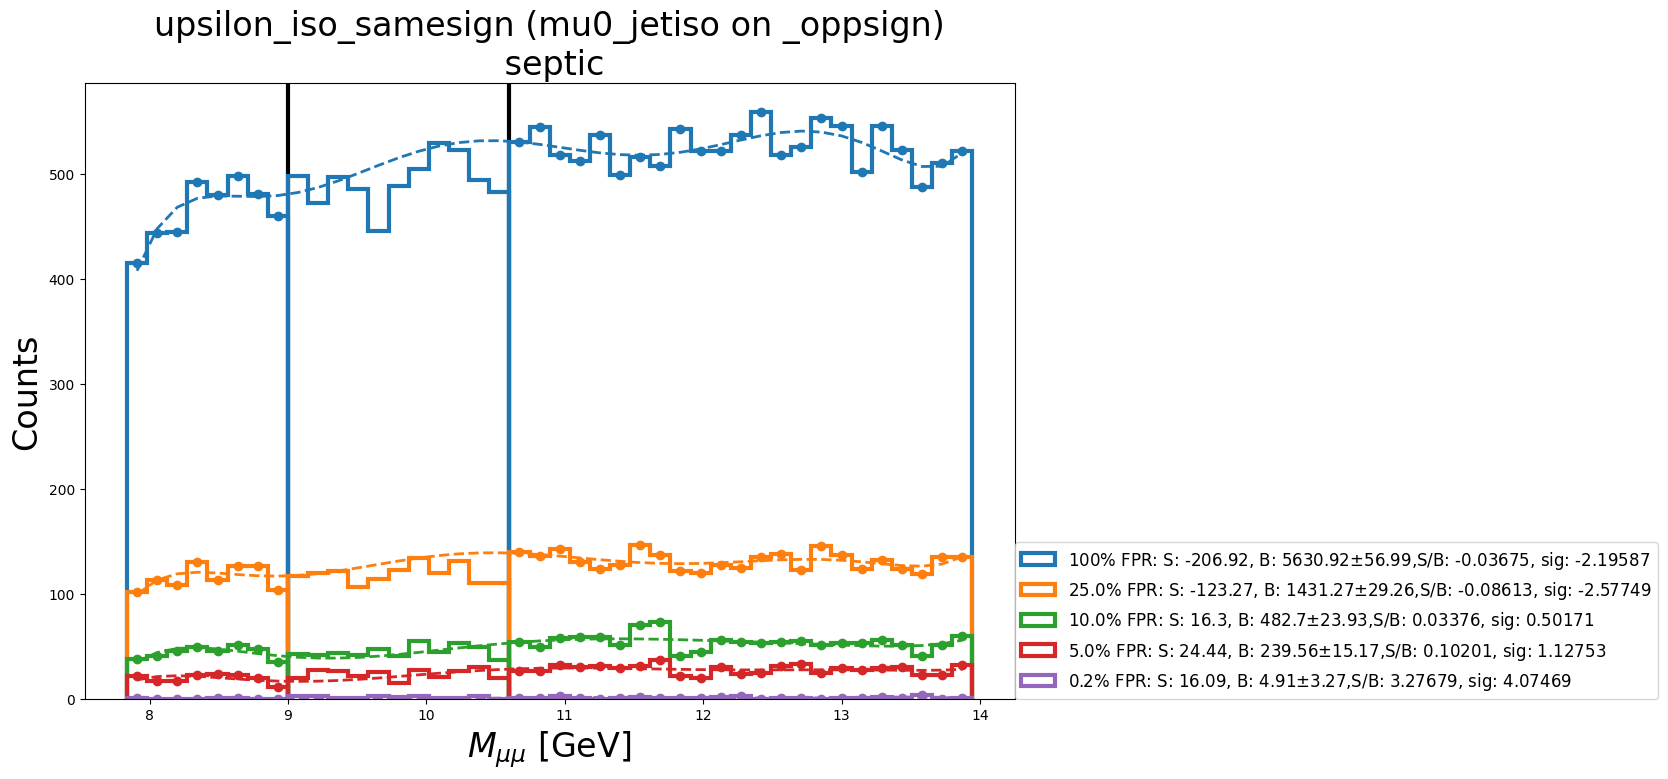

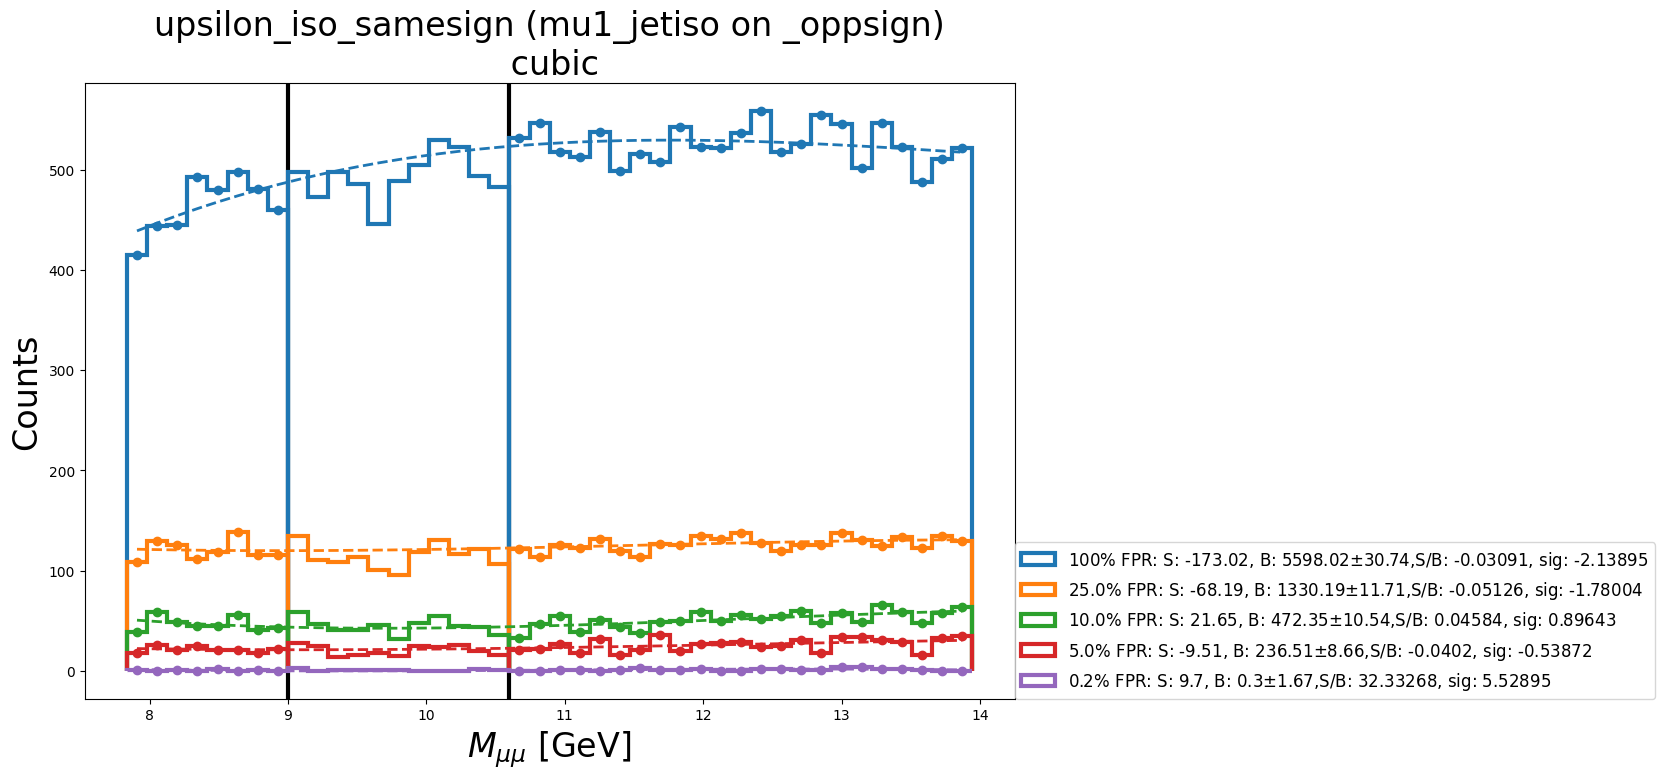

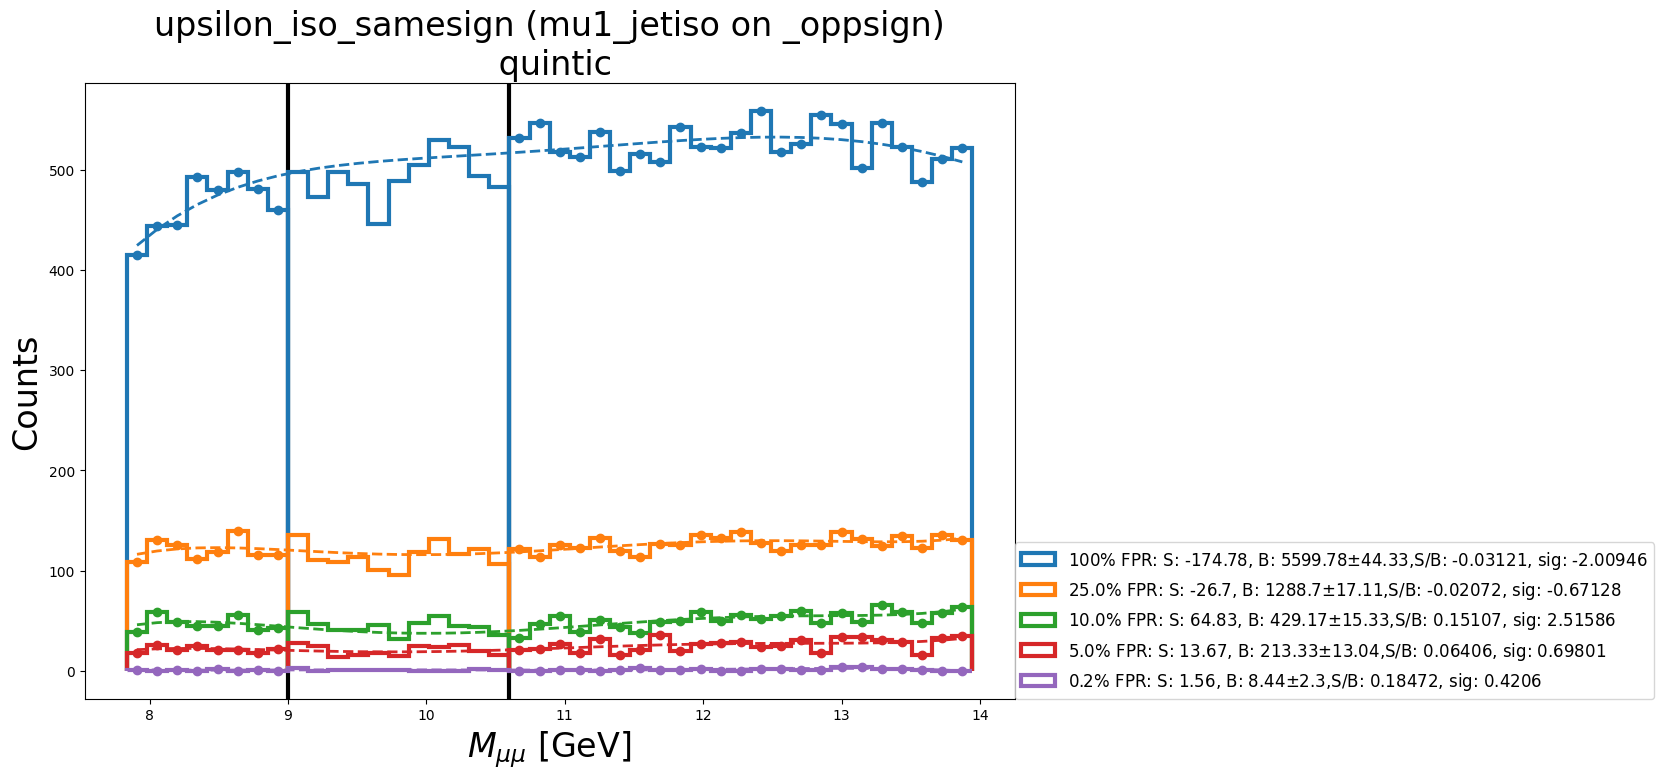

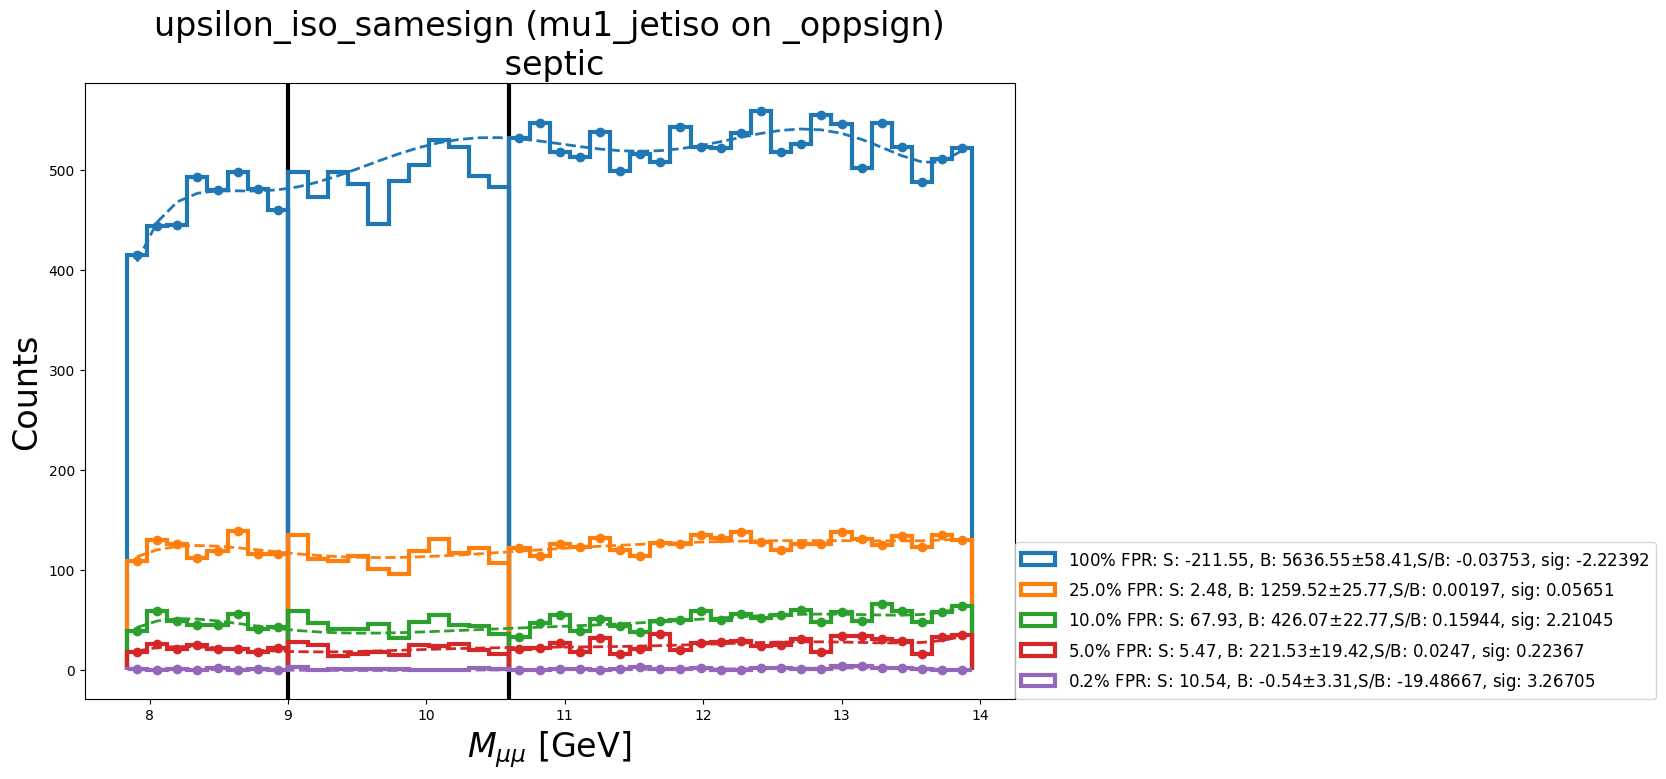

In [51]:
# Same thing for the alternative test data

for feature in feature_set[:-1]:
    print(feature)
    fpr_results_cubic = plot_feature_cuts(feature, fpr_thresholds, alt_test_data_dict, scaler, "cubic", f"{particle_type}{alt_test_data_id} ({feature} on {train_data_id_title})\n cubic", SB_left, SR_left, SR_right, SB_right)
    fpr_results_quintic = plot_feature_cuts(feature, fpr_thresholds, alt_test_data_dict, scaler, "quintic", f"{particle_type}{alt_test_data_id} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right)
    fpr_results_septic = plot_feature_cuts(feature, fpr_thresholds, alt_test_data_dict, scaler, "septic", f"{particle_type}{alt_test_data_id} ({feature} on {train_data_id_title})\n septic", SB_left, SR_left, SR_right, SB_right)
    for f in fpr_results_septic.keys():
        print(f"Threshold {100*f}%")
        print("   cubic // quintic // septic")
        print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
        print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
        print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
        print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))